In [2]:
import numpy as np
import pandas as pd
import h5py
import os
import glob
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import matplotlib.dates as md
import warnings
from scipy.interpolate import interp2d
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')
import scipy.ndimage as ndimage
from matplotlib import cm
from matplotlib.colors import LogNorm
from sklearn import preprocessing
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats

In [90]:
def simple_read(path):
    with open(path) as f:
        first_line = f.readline()
        header_line = int(first_line[0:-2].split(",")[0])-1
        #all_lines = f.readlines()
    data = pd.read_csv(path, sep=',', skiprows=header_line)
    data.columns = [i.strip() for i in data.columns]
    #date = all_lines[5][0:10].split(',')
    #dt = datetime(int(date[0]), int(date[1]), int(date[2]))

    acc = 0
    boo = False
    for letter in path:
        if letter == '2':
            boo = True
        elif boo and letter == '0':
            acc -= 1
            break
        acc += 1
    #print(path[:acc+4], path[acc+4:acc+6], path[acc+6:acc+8])
    dt = datetime(int(path[acc:acc+4]), int(path[acc+4:acc+6]), int(path[acc+6:acc+8]))
    
    for column in data.keys():
        if 'Time' in column:
            data[column] = dt + pd.to_timedelta(data[column], unit='seconds')
    return data.replace(-999999, np.NaN)

In [93]:
DAY22 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220602_R0_L1_20230614T111634.ict')

start_index = np.where(DAY22["Time_Start"] == pd.to_datetime("2022-06-02 12:58:55"))
stop_index = np.where(DAY22["Time_Start"] == pd.to_datetime("2022-06-02 13:10:00"))

DAY22_subset = DAY22[start_index[0][0]:stop_index[0][0]]

# Print the modified subset dataframe
DAY22_subset


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
5981,2022-06-02 12:58:55,2022-06-02 12:58:56,32.901061,-69.417865,115.705,0.314,1.592,-0.017,0.700,0.009,0.011
5982,2022-06-02 12:58:56,2022-06-02 12:58:57,32.901505,-69.416658,115.605,0.314,1.592,-0.017,0.700,0.009,0.011
5983,2022-06-02 12:58:57,2022-06-02 12:58:58,32.901950,-69.415451,114.775,0.314,1.592,-0.017,0.700,0.009,0.011
5984,2022-06-02 12:58:58,2022-06-02 12:58:59,32.902395,-69.414241,113.025,0.314,1.592,-0.017,0.700,0.009,0.011
5985,2022-06-02 12:58:59,2022-06-02 12:59:00,32.902841,-69.413027,110.485,0.314,1.592,-0.017,0.700,0.009,0.011
...,...,...,...,...,...,...,...,...,...,...,...
6641,2022-06-02 13:09:55,2022-06-02 13:09:56,32.856578,-69.176604,3810.860,0.437,0.139,-0.021,0.195,0.007,0.029
6642,2022-06-02 13:09:56,2022-06-02 13:09:57,32.856534,-69.174895,3811.410,0.437,0.139,-0.021,0.195,0.007,0.029
6643,2022-06-02 13:09:57,2022-06-02 13:09:58,32.856492,-69.173186,3812.340,0.437,0.139,-0.021,0.195,0.007,0.029
6644,2022-06-02 13:09:58,2022-06-02 13:09:59,32.856451,-69.171477,3813.680,0.437,0.139,-0.021,0.195,0.007,0.029


In [94]:
normal = (DAY22_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY22_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY22_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY22_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY22_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY22_subset['mz44'] = DAY22_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY22_subset['Org_Ave_IsoK_STP_ZIEMBA']
DAY22_subset





,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44
5981,2022-06-02 12:58:55,2022-06-02 12:58:56,32.901061,-69.417865,115.705,0.314,1.592,-0.017,0.700,0.009,0.011,0.035032
5982,2022-06-02 12:58:56,2022-06-02 12:58:57,32.901505,-69.416658,115.605,0.314,1.592,-0.017,0.700,0.009,0.011,0.035032
5983,2022-06-02 12:58:57,2022-06-02 12:58:58,32.901950,-69.415451,114.775,0.314,1.592,-0.017,0.700,0.009,0.011,0.035032
5984,2022-06-02 12:58:58,2022-06-02 12:58:59,32.902395,-69.414241,113.025,0.314,1.592,-0.017,0.700,0.009,0.011,0.035032
5985,2022-06-02 12:58:59,2022-06-02 12:59:00,32.902841,-69.413027,110.485,0.314,1.592,-0.017,0.700,0.009,0.011,0.035032
...,...,...,...,...,...,...,...,...,...,...,...,...
6641,2022-06-02 13:09:55,2022-06-02 13:09:56,32.856578,-69.176604,3810.860,0.437,0.139,-0.021,0.195,0.007,0.029,0.066362
6642,2022-06-02 13:09:56,2022-06-02 13:09:57,32.856534,-69.174895,3811.410,0.437,0.139,-0.021,0.195,0.007,0.029,0.066362
6643,2022-06-02 13:09:57,2022-06-02 13:09:58,32.856492,-69.173186,3812.340,0.437,0.139,-0.021,0.195,0.007,0.029,0.066362
6644,2022-06-02 13:09:58,2022-06-02 13:09:59,32.856451,-69.171477,3813.680,0.437,0.139,-0.021,0.195,0.007,0.029,0.066362


In [96]:
# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY22_subset.loc[:, start_col2:stop_col2] = DAY22_subset.loc[:, start_col2:stop_col2].div(normal, axis=0)
DAY22_subset['AMS'] = normal
DAY22_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
5981,2022-06-02 12:58:55,2022-06-02 12:58:56,32.901061,-69.417865,115.705,0.046521,0.235866,-0.002519,0.103710,0.001333,0.011,0.035032,2.598
5982,2022-06-02 12:58:56,2022-06-02 12:58:57,32.901505,-69.416658,115.605,0.046521,0.235866,-0.002519,0.103710,0.001333,0.011,0.035032,2.598
5983,2022-06-02 12:58:57,2022-06-02 12:58:58,32.901950,-69.415451,114.775,0.046521,0.235866,-0.002519,0.103710,0.001333,0.011,0.035032,2.598
5984,2022-06-02 12:58:58,2022-06-02 12:58:59,32.902395,-69.414241,113.025,0.046521,0.235866,-0.002519,0.103710,0.001333,0.011,0.035032,2.598
5985,2022-06-02 12:58:59,2022-06-02 12:59:00,32.902841,-69.413027,110.485,0.046521,0.235866,-0.002519,0.103710,0.001333,0.011,0.035032,2.598
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6641,2022-06-02 13:09:55,2022-06-02 13:09:56,32.856578,-69.176604,3810.860,0.762587,0.242562,-0.036646,0.340285,0.012215,0.029,0.066362,0.757
6642,2022-06-02 13:09:56,2022-06-02 13:09:57,32.856534,-69.174895,3811.410,0.762587,0.242562,-0.036646,0.340285,0.012215,0.029,0.066362,0.757
6643,2022-06-02 13:09:57,2022-06-02 13:09:58,32.856492,-69.173186,3812.340,0.762587,0.242562,-0.036646,0.340285,0.012215,0.029,0.066362,0.757
6644,2022-06-02 13:09:58,2022-06-02 13:09:59,32.856451,-69.171477,3813.680,0.762587,0.242562,-0.036646,0.340285,0.012215,0.029,0.066362,0.757


In [85]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY22_subset.GPS_Altitude_THORNHILL.min(), DAY22_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY22_subset['Bins'] = pd.cut(DAY22_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY22_subset_1000 = DAY22_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY22_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY22_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000a = DAY22_subset_1000[start_index:stop_index]
DAY1000_subset_1000a


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(105.985, 143.17]",2022-06-02 12:59:00.916666624,2022-06-02 12:59:01.916666624,32.903710,-69.410654,115.808333,0.120862,0.612779,-0.006543,0.269438,0.003464,0.011000,0.035032,2.598000
"(143.17, 180.354]",2022-06-02 12:59:09.500000000,2022-06-02 12:59:10.500000000,32.907639,-69.400134,160.330000,0.120862,0.612779,-0.006543,0.269438,0.003464,0.011000,0.035032,2.598000
"(180.354, 217.539]",2022-06-02 12:59:14.500000000,2022-06-02 12:59:15.500000000,32.910276,-69.394233,198.897500,0.120862,0.612779,-0.006543,0.269438,0.003464,0.011000,0.035032,2.598000
"(217.539, 254.723]",2022-06-02 12:59:20.500000000,2022-06-02 12:59:21.500000000,32.914387,-69.387901,235.363333,0.224719,0.557854,-0.019956,0.237985,-0.000602,0.034333,0.052669,2.788833
"(254.723, 291.908]",2022-06-02 12:59:26.000000000,2022-06-02 12:59:27.000000000,32.919110,-69.383256,275.971000,0.245490,0.546869,-0.022639,0.231694,-0.001415,0.039000,0.056196,2.827000
"(291.908, 329.092]",2022-06-02 12:59:32.000000000,2022-06-02 12:59:33.000000000,32.925158,-69.379916,306.361429,0.245490,0.546869,-0.022639,0.231694,-0.001415,0.039000,0.056196,2.827000
"(329.092, 366.277]",2022-06-02 12:59:37.000000256,2022-06-02 12:59:38.000000000,32.930599,-69.378614,345.360000,0.245490,0.546869,-0.022639,0.231694,-0.001415,0.039000,0.056196,2.827000
"(366.277, 403.461]",2022-06-02 12:59:40.500000000,2022-06-02 12:59:41.500000000,32.934449,-69.378690,383.370000,0.245490,0.546869,-0.022639,0.231694,-0.001415,0.039000,0.056196,2.827000
"(403.461, 440.646]",2022-06-02 12:59:45.500000000,2022-06-02 12:59:46.500000000,32.939832,-69.379889,420.896667,0.245490,0.546869,-0.022639,0.231694,-0.001415,0.039000,0.056196,2.827000


In [7]:

#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY22_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY22_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000a = DAY22_subset_1000[start_index:stop_index]
DAY3000_subset_3000a

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(998.414, 1035.599]",2022-06-02 13:00:58.500,2022-06-02 13:00:59.500,32.926080,-69.440850,1020.315000,0.254849,0.674916,-0.005351,0.074247,0.001338,0.03000,0.078740,1.4950
"(1035.599, 1072.783]",2022-06-02 13:01:03.000,2022-06-02 13:01:04.000,32.921042,-69.439285,1056.798000,0.254849,0.674916,-0.005351,0.074247,0.001338,0.03000,0.078740,1.4950
"(1072.783, 1109.968]",2022-06-02 13:01:08.000,2022-06-02 13:01:09.000,32.915715,-69.436411,1089.958000,0.254849,0.674916,-0.005351,0.074247,0.001338,0.03000,0.078740,1.4950
"(1109.968, 1147.152]",2022-06-02 13:01:13.000,2022-06-02 13:01:14.000,32.910909,-69.432319,1128.646000,0.254849,0.674916,-0.005351,0.074247,0.001338,0.03000,0.078740,1.4950
"(1147.152, 1184.337]",2022-06-02 13:01:17.500,2022-06-02 13:01:18.500,32.907190,-69.427734,1167.085000,0.266094,0.609700,0.000413,0.121077,0.002717,0.02175,0.057627,1.5590
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3266.672, 3303.856]",2022-06-02 13:06:03.500,2022-06-02 13:06:04.500,32.971710,-69.393733,3284.793333,0.147872,0.248936,0.045745,0.571277,-0.013830,-0.02900,-0.208633,0.9400
"(3303.856, 3341.041]",2022-06-02 13:06:09.000,2022-06-02 13:06:10.000,32.970036,-69.401495,3322.750000,0.147872,0.248936,0.045745,0.571277,-0.013830,-0.02900,-0.208633,0.9400
"(3341.041, 3378.225]",2022-06-02 13:06:13.500,2022-06-02 13:06:14.500,32.967751,-69.407443,3359.957500,0.147872,0.248936,0.045745,0.571277,-0.013830,-0.02900,-0.208633,0.9400


In [8]:
DAY2 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220602_R0_L1_20230614T111634.ict')
start_index = np.where(DAY2["Time_Start"]==pd.to_datetime("2022-06-02 13:48:00"))
stop_index = np.where(DAY2["Time_Start"]==pd.to_datetime("2022-06-02 14:11:00"))
    
DAY2_subset = DAY2[start_index[0][0]:stop_index[0][0]]
DAY2_subset = DAY2_subset.replace(-888888, 0)
DAY2_subset


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
8926,2022-06-02 13:48:00,2022-06-02 13:48:01,32.397719,-65.920473,1896.68,0.241,0.453,0.108,0.114,0.008,-0.049
8927,2022-06-02 13:48:01,2022-06-02 13:48:02,32.397400,-65.918900,1897.28,0.241,0.453,0.108,0.114,0.008,-0.049
8928,2022-06-02 13:48:02,2022-06-02 13:48:03,32.397079,-65.917327,1898.01,0.241,0.453,0.108,0.114,0.008,-0.049
8929,2022-06-02 13:48:03,2022-06-02 13:48:04,32.396758,-65.915754,1898.83,0.241,0.453,0.108,0.114,0.008,-0.049
8930,2022-06-02 13:48:04,2022-06-02 13:48:05,32.396435,-65.914182,1899.75,0.241,0.453,0.108,0.114,0.008,-0.049
...,...,...,...,...,...,...,...,...,...,...,...
10301,2022-06-02 14:10:55,2022-06-02 14:10:56,32.264343,-65.038703,3176.07,0.025,0.127,0.054,0.261,-0.012,-0.051
10302,2022-06-02 14:10:56,2022-06-02 14:10:57,32.263327,-65.039317,3180.14,0.025,0.127,0.054,0.261,-0.012,-0.051
10303,2022-06-02 14:10:57,2022-06-02 14:10:58,32.262289,-65.039886,3184.23,0.025,0.127,0.054,0.261,-0.012,-0.051
10304,2022-06-02 14:10:58,2022-06-02 14:10:59,32.261232,-65.040413,3188.41,0.025,0.127,0.054,0.261,-0.012,-0.051


In [9]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2_subset.GPS_Altitude_THORNHILL.min(), DAY2_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2_subset['Bins'] = pd.cut(DAY2_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2_subset_1000 = DAY2_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000 = DAY2_subset_1000[start_index:stop_index]
DAY1000_subset_1000


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(106.28, 137.146]",2022-06-02 13:58:08.320987648,2022-06-02 13:58:09.320987648,32.208644,-65.046952,122.186728,0.373099,1.455358,0.030642,0.535802,0.022519,-0.027667
"(137.146, 168.011]",2022-06-02 13:58:10.518518528,2022-06-02 13:58:11.518518528,32.213469,-65.043230,151.951296,0.406593,1.455296,0.032111,0.620926,0.070444,0.014667
"(168.011, 198.876]",2022-06-02 13:58:12.705882368,2022-06-02 13:58:13.705882368,32.219749,-65.042162,181.117059,0.394471,1.482235,0.018882,0.550765,0.024588,0.029941
"(198.876, 229.742]",2022-06-02 13:57:58.000000000,2022-06-02 13:57:58.999999744,32.227033,-65.060908,215.937917,0.483417,1.480917,0.002417,0.534000,-0.030917,0.043667
"(229.742, 260.607]",2022-06-02 13:57:56.000000000,2022-06-02 13:57:57.000000256,32.230811,-65.065096,247.461667,0.483417,1.480917,0.002417,0.534000,-0.030917,0.043667
"(260.607, 291.473]",2022-06-02 13:58:33.000000000,2022-06-02 13:58:34.000000000,32.233699,-65.031089,277.609000,0.500450,1.479750,-0.002950,0.531200,-0.026950,0.033400
"(291.473, 322.338]",2022-06-02 13:57:58.875000064,2022-06-02 13:57:59.875000064,32.242170,-65.072916,306.906875,0.258813,1.461812,0.008250,0.498812,-0.018188,0.005187
"(322.338, 353.204]",2022-06-02 13:57:36.500000000,2022-06-02 13:57:37.500000000,32.246461,-65.098823,337.648333,-0.034000,1.437667,0.018333,0.451667,-0.006667,-0.035667
"(353.204, 384.069]",2022-06-02 13:58:22.142857216,2022-06-02 13:58:23.142856960,32.248907,-65.059617,370.370714,0.011000,1.435286,0.010714,0.431429,-0.015714,-0.031857


In [10]:

#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000 = DAY2_subset_1000[start_index:stop_index]
DAY3000_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(1001.379, 1032.245]",2022-06-02 13:58:29.750000128,2022-06-02 13:58:30.750000128,32.266385,-65.180821,1016.933750,0.198250,1.096625,0.094125,0.458250,0.012375,-0.056000
"(1032.245, 1063.11]",2022-06-02 13:59:37.272727296,2022-06-02 13:59:38.272727296,32.260882,-65.118855,1049.908182,0.224636,1.119636,0.107727,0.411000,0.015545,-0.060909
"(1063.11, 1093.976]",2022-06-02 13:59:02.666666752,2022-06-02 13:59:03.666666496,32.270422,-65.152259,1077.432222,0.209000,1.106000,0.099667,0.439000,0.013667,-0.058000
"(1093.976, 1124.842]",2022-06-02 13:59:05.666666752,2022-06-02 13:59:06.666666752,32.274568,-65.151632,1109.315556,0.149889,1.022444,0.060111,0.415444,-0.001889,-0.055333
"(1124.842, 1155.707]",2022-06-02 13:59:31.000000000,2022-06-02 13:59:32.000000000,32.276951,-65.131516,1139.676000,0.124500,0.981900,0.041800,0.386500,-0.009800,-0.055400
...,...,...,...,...,...,...,...,...,...,...,...
"(3007.637, 3038.502]",2022-06-02 14:10:25.500000000,2022-06-02 14:10:26.500000000,32.281711,-65.007357,3024.312500,0.636000,0.244000,0.045000,-0.174000,0.028000,0.076000
"(3038.502, 3069.368]",2022-06-02 14:10:32.000000000,2022-06-02 14:10:33.000000000,32.280272,-65.015718,3054.334000,0.636000,0.244000,0.045000,-0.174000,0.028000,0.076000
"(3069.368, 3100.234]",2022-06-02 14:10:36.500000000,2022-06-02 14:10:37.500000000,32.278421,-65.021210,3084.770000,0.636000,0.244000,0.045000,-0.174000,0.028000,0.076000


In [11]:
DAY2b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220602_R0_L2_20230614T111634.ict')
start_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:36:00"))
stop_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:53:00"))
DAY2b_subset = DAY2b[start_index[0][0]:stop_index[0][0]]
DAY2b_subset = DAY2b_subset.replace(-888888, 0)
DAY2b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
9180,2022-06-02 18:36:00,2022-06-02 18:36:01,32.312301,-65.009805,191.225,0.669,1.479,-0.051,0.057,0.028,-0.033
9181,2022-06-02 18:36:01,2022-06-02 18:36:02,32.312336,-65.010962,193.480,0.669,1.479,-0.051,0.057,0.028,-0.033
9182,2022-06-02 18:36:02,2022-06-02 18:36:03,32.312332,-65.012116,195.600,0.669,1.479,-0.051,0.057,0.028,-0.033
9183,2022-06-02 18:36:03,2022-06-02 18:36:04,32.312294,-65.013268,197.010,0.669,1.479,-0.051,0.057,0.028,-0.033
9184,2022-06-02 18:36:04,2022-06-02 18:36:05,32.312221,-65.014415,197.440,0.669,1.479,-0.051,0.057,0.028,-0.033
...,...,...,...,...,...,...,...,...,...,...,...
10195,2022-06-02 18:52:55,2022-06-02 18:52:56,32.205808,-64.977280,3678.610,0.836,0.176,0.024,-0.174,-0.012,0.066
10196,2022-06-02 18:52:56,2022-06-02 18:52:57,32.205215,-64.976028,3684.900,0.836,0.176,0.024,-0.174,-0.012,0.066
10197,2022-06-02 18:52:57,2022-06-02 18:52:58,32.204648,-64.974760,3691.340,0.836,0.176,0.024,-0.174,-0.012,0.066
10198,2022-06-02 18:52:58,2022-06-02 18:52:59,32.204104,-64.973478,3697.790,0.836,0.176,0.024,-0.174,-0.012,0.066


In [12]:
normal2 = (DAY2b_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY2b_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY2b_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY2b_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY2b_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY2b_subset['mz44'] = DAY2b_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY2b_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY2b_subset.loc[:, start_col2:stop_col2] = DAY2b_subset.loc[:, start_col2:stop_col2].div(normal2, axis=0)
DAY2b_subset['AMS'] = normal2
DAY2b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
9180,2022-06-02 18:36:00,2022-06-02 18:36:01,32.312301,-65.009805,191.225,0.306599,0.677819,-0.023373,0.026123,0.012832,-0.033,-0.049327,2.182
9181,2022-06-02 18:36:01,2022-06-02 18:36:02,32.312336,-65.010962,193.480,0.306599,0.677819,-0.023373,0.026123,0.012832,-0.033,-0.049327,2.182
9182,2022-06-02 18:36:02,2022-06-02 18:36:03,32.312332,-65.012116,195.600,0.306599,0.677819,-0.023373,0.026123,0.012832,-0.033,-0.049327,2.182
9183,2022-06-02 18:36:03,2022-06-02 18:36:04,32.312294,-65.013268,197.010,0.306599,0.677819,-0.023373,0.026123,0.012832,-0.033,-0.049327,2.182
9184,2022-06-02 18:36:04,2022-06-02 18:36:05,32.312221,-65.014415,197.440,0.306599,0.677819,-0.023373,0.026123,0.012832,-0.033,-0.049327,2.182
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,2022-06-02 18:52:55,2022-06-02 18:52:56,32.205808,-64.977280,3678.610,0.983529,0.207059,0.028235,-0.204706,-0.014118,0.066,0.078947,0.850
10196,2022-06-02 18:52:56,2022-06-02 18:52:57,32.205215,-64.976028,3684.900,0.983529,0.207059,0.028235,-0.204706,-0.014118,0.066,0.078947,0.850
10197,2022-06-02 18:52:57,2022-06-02 18:52:58,32.204648,-64.974760,3691.340,0.983529,0.207059,0.028235,-0.204706,-0.014118,0.066,0.078947,0.850
10198,2022-06-02 18:52:58,2022-06-02 18:52:59,32.204104,-64.973478,3697.790,0.983529,0.207059,0.028235,-0.204706,-0.014118,0.066,0.078947,0.850


In [13]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2b_subset.GPS_Altitude_THORNHILL.min(), DAY2b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2b_subset['Bins'] = pd.cut(DAY2b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2b_subset_1000 = DAY2b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000b = DAY2b_subset_1000[start_index:stop_index]
DAY1000_subset_1000b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(132.5, 168.217]",2022-06-02 18:36:33.700000000,2022-06-02 18:36:34.700,32.294115,-65.038343,150.110167,0.247774,0.668646,0.036235,0.024961,0.022385,0.002000,0.005566,2.284500
"(168.217, 203.933]",2022-06-02 18:36:19.440000000,2022-06-02 18:36:20.440,32.302282,-65.024822,185.682600,0.280965,0.673850,-0.007224,0.037155,0.015254,-0.018200,-0.015687,2.205520
"(203.933, 239.65]",2022-06-02 18:37:02.000000000,2022-06-02 18:37:03.000,32.265794,-65.038727,217.346923,0.127354,0.650224,0.035426,0.166816,0.020179,0.068000,0.239437,2.230000
"(239.65, 275.366]",2022-06-02 18:37:13.000000000,2022-06-02 18:37:14.000,32.254753,-65.034836,258.630000,0.127354,0.650224,0.035426,0.166816,0.020179,0.068000,0.239437,2.230000
"(275.366, 311.083]",2022-06-02 18:37:23.999999744,2022-06-02 18:37:25.000,32.245202,-65.026887,290.658077,0.083055,0.668156,0.023730,0.209023,0.016037,0.051846,0.400905,2.024615
"(311.083, 346.8]",2022-06-02 18:37:38.000000000,2022-06-02 18:37:39.000,32.237366,-65.011798,330.868333,0.031373,0.689076,0.010084,0.258263,0.011204,0.033000,0.589286,1.785000
"(346.8, 382.516]",2022-06-02 18:37:53.000000000,2022-06-02 18:37:54.000,32.237006,-64.992797,363.542667,0.079544,0.656800,0.008413,0.254190,0.001052,0.021000,0.358241,1.748200
"(382.516, 418.233]",2022-06-02 18:38:07.000000000,2022-06-02 18:38:08.000,32.244580,-64.977394,399.478462,0.151802,0.608387,0.005907,0.248080,-0.014176,0.003000,0.011673,1.693000
"(418.233, 453.949]",2022-06-02 18:38:19.000000000,2022-06-02 18:38:20.000,32.255481,-64.969336,433.617273,0.151802,0.608387,0.005907,0.248080,-0.014176,0.003000,0.011673,1.693000


In [14]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000b = DAY2b_subset_1000[start_index:stop_index]
DAY3000_subset_3000b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(989.698, 1025.415]",2022-06-02 18:41:23.000,2022-06-02 18:41:24.000,32.269884,-64.947261,1010.109286,0.242646,0.598171,-0.000838,0.156117,0.003906,-0.003000,-0.103645,1.450571
"(1025.415, 1061.132]",2022-06-02 18:41:31.500,2022-06-02 18:41:32.500,32.278879,-64.945764,1045.848000,0.068655,0.590846,0.019417,0.331484,-0.010402,-0.043000,-0.434343,1.442000
"(1061.132, 1096.848]",2022-06-02 18:41:40.500,2022-06-02 18:41:41.500,32.288298,-64.947187,1080.382500,0.068655,0.590846,0.019417,0.331484,-0.010402,-0.043000,-0.434343,1.442000
"(1096.848, 1132.565]",2022-06-02 18:41:52.500,2022-06-02 18:41:53.500,32.298942,-64.954631,1113.911250,0.108788,0.636576,0.028347,0.234966,-0.008677,-0.008875,-0.141550,1.217563
"(1132.565, 1168.281]",2022-06-02 18:42:04.500,2022-06-02 18:42:05.500,32.306134,-64.966376,1149.516250,0.160388,0.695371,0.039828,0.110872,-0.006459,0.035000,0.234899,0.929000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3275.561, 3311.277]",2022-06-02 18:51:48.500,2022-06-02 18:51:49.500,32.275042,-65.008035,3293.825000,0.323725,0.399113,-0.106430,0.325942,0.057650,-0.033000,-0.226027,0.451000
"(3311.277, 3346.994]",2022-06-02 18:51:54.000,2022-06-02 18:51:55.000,32.268640,-65.008707,3329.810000,0.364525,0.376424,-0.058786,0.252812,0.065025,-0.028200,-0.171361,0.491400
"(3346.994, 3382.711]",2022-06-02 18:51:59.000,2022-06-02 18:52:00.000,32.262832,-65.009195,3366.570000,0.425725,0.342391,0.012681,0.143116,0.076087,-0.021000,-0.089362,0.552000


In [15]:
DAY3 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220603_R0_20230614T111635.ict')
start_index= np.where(DAY3["Time_Start"]==pd.to_datetime("2022-06-03 13:30:00"))
stop_index= np.where(DAY3["Time_Start"]==pd.to_datetime("2022-06-03 15:00:00"))
    
DAY3_subset = DAY3[start_index[0][0]:stop_index[0][0]]
DAY3_subset = DAY3_subset.replace(-888888, 0)
DAY3_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
2467,2022-06-03 13:30:00,2022-06-03 13:30:01,33.872982,-67.052387,2858.90,0.343,0.244,-0.017,0.025,-0.002,0.050
2468,2022-06-03 13:30:01,2022-06-03 13:30:02,33.872534,-67.053832,2861.55,0.343,0.244,-0.017,0.025,-0.002,0.050
2469,2022-06-03 13:30:02,2022-06-03 13:30:03,33.872086,-67.055272,2863.82,0.343,0.244,-0.017,0.025,-0.002,0.050
2470,2022-06-03 13:30:03,2022-06-03 13:30:04,33.871638,-67.056704,2865.57,0.343,0.244,-0.017,0.025,-0.002,0.050
2471,2022-06-03 13:30:04,2022-06-03 13:30:05,33.871187,-67.058127,2866.59,0.343,0.244,-0.017,0.025,-0.002,0.050
...,...,...,...,...,...,...,...,...,...,...,...
7862,2022-06-03 14:59:55,2022-06-03 14:59:56,32.712767,-65.244314,2413.61,0.003,0.199,0.020,0.215,0.022,-0.014
7863,2022-06-03 14:59:56,2022-06-03 14:59:57,32.712103,-65.243151,2408.15,0.003,0.199,0.020,0.215,0.022,-0.014
7864,2022-06-03 14:59:57,2022-06-03 14:59:58,32.711441,-65.241989,2402.02,0.003,0.199,0.020,0.215,0.022,-0.014
7865,2022-06-03 14:59:58,2022-06-03 14:59:59,32.710779,-65.240827,2395.43,0.003,0.199,0.020,0.215,0.022,-0.014


In [16]:
normal3 = (DAY3_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY3_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY3_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY3_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY3_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY3_subset['mz44'] = DAY3_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY3_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY3_subset.loc[:, start_col2:stop_col2] = DAY3_subset.loc[:, start_col2:stop_col2].div(normal3, axis=0)
DAY3_subset['AMS'] = normal3
DAY3_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
2467,2022-06-03 13:30:00,2022-06-03 13:30:01,33.872982,-67.052387,2858.90,0.578415,0.411467,-0.028668,0.042159,-0.003373,0.050,0.145773,0.593
2468,2022-06-03 13:30:01,2022-06-03 13:30:02,33.872534,-67.053832,2861.55,0.578415,0.411467,-0.028668,0.042159,-0.003373,0.050,0.145773,0.593
2469,2022-06-03 13:30:02,2022-06-03 13:30:03,33.872086,-67.055272,2863.82,0.578415,0.411467,-0.028668,0.042159,-0.003373,0.050,0.145773,0.593
2470,2022-06-03 13:30:03,2022-06-03 13:30:04,33.871638,-67.056704,2865.57,0.578415,0.411467,-0.028668,0.042159,-0.003373,0.050,0.145773,0.593
2471,2022-06-03 13:30:04,2022-06-03 13:30:05,33.871187,-67.058127,2866.59,0.578415,0.411467,-0.028668,0.042159,-0.003373,0.050,0.145773,0.593
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7862,2022-06-03 14:59:55,2022-06-03 14:59:56,32.712767,-65.244314,2413.61,0.006536,0.433551,0.043573,0.468410,0.047930,-0.014,-4.666667,0.459
7863,2022-06-03 14:59:56,2022-06-03 14:59:57,32.712103,-65.243151,2408.15,0.006536,0.433551,0.043573,0.468410,0.047930,-0.014,-4.666667,0.459
7864,2022-06-03 14:59:57,2022-06-03 14:59:58,32.711441,-65.241989,2402.02,0.006536,0.433551,0.043573,0.468410,0.047930,-0.014,-4.666667,0.459
7865,2022-06-03 14:59:58,2022-06-03 14:59:59,32.710779,-65.240827,2395.43,0.006536,0.433551,0.043573,0.468410,0.047930,-0.014,-4.666667,0.459


In [17]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY3_subset.GPS_Altitude_THORNHILL.min(), DAY3_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY3_subset['Bins'] = pd.cut(DAY3_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY3_subset_1000 = DAY3_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_3 = DAY3_subset_1000[start_index:stop_index]
DAY1000_subset_3


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(94.825, 149.89]",2022-06-03 13:45:28.789007104,2022-06-03 13:45:29.789007104,34.126959,-67.213208,123.892358,0.226035,0.615974,0.005921,0.151690,0.000381,0.035413,0.061675,2.311074
"(149.89, 204.956]",2022-06-03 13:48:10.320000000,2022-06-03 13:48:11.319999744,33.927509,-67.395937,181.520500,0.269130,0.550642,0.033513,0.140180,0.006535,0.077720,0.106176,2.396220
"(204.956, 260.021]",2022-06-03 13:59:27.145491712,2022-06-03 13:59:28.145491712,34.102741,-67.396328,246.379939,0.178687,0.640530,0.014309,0.163221,0.003253,0.015936,-0.014753,2.349184
"(260.021, 315.086]",2022-06-03 13:53:11.011236096,2022-06-03 13:53:12.011235840,33.997827,-67.380569,280.595730,0.186761,0.662707,0.015648,0.134865,0.000019,0.020461,0.024999,2.143584
"(315.086, 370.151]",2022-06-03 13:54:31.023809536,2022-06-03 13:54:32.023809536,34.037034,-67.328911,340.301310,0.169653,0.677703,0.011598,0.138903,0.002142,0.034857,0.067674,2.140929
"(370.151, 425.217]",2022-06-03 13:54:07.136363520,2022-06-03 13:54:08.136363776,34.095859,-67.060673,402.749318,0.111311,0.699344,0.007809,0.185070,-0.003535,0.028091,0.402068,2.139727
"(425.217, 480.282]",2022-06-03 14:03:16.657894656,2022-06-03 14:03:17.657894656,34.148126,-67.167576,453.531184,-0.007000,0.869809,0.007707,0.134439,-0.004956,-0.065333,0.779749,1.760000
"(480.282, 535.347]",2022-06-03 14:09:48.304114432,2022-06-03 14:09:49.304114688,34.166931,-67.301055,500.509848,0.154862,0.663589,0.010164,0.163994,0.007390,0.029541,0.056488,2.524010
"(535.347, 590.412]",2022-06-03 13:56:08.066666752,2022-06-03 13:56:09.066666752,33.903960,-67.359933,562.995667,0.035211,0.730134,0.023280,0.195741,0.015634,0.025889,-1.516820,1.333667


In [18]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3_subset_3000 = DAY3_subset_1000[start_index:stop_index]
DAY3_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(975.869, 1030.934]",2022-06-03 14:08:35.406249984,2022-06-03 14:08:36.406249984,34.003272,-67.474357,1004.015000,0.219316,0.668005,-0.000037,0.126571,-0.013855,0.007438,0.018737,1.255437
"(1030.934, 1086.0]",2022-06-03 14:10:41.310344960,2022-06-03 14:10:42.310344960,34.016593,-67.498275,1060.067931,0.220623,0.652696,-0.010780,0.155295,-0.017835,-0.004862,-0.085929,1.251207
"(1086.0, 1141.065]",2022-06-03 14:08:44.529411840,2022-06-03 14:08:45.529411840,33.996922,-67.516110,1107.793824,0.217924,0.606992,-0.009246,0.187071,-0.002740,-0.012353,-0.103505,1.261882
"(1141.065, 1196.13]",2022-06-03 13:54:16.100000000,2022-06-03 13:54:17.100000000,34.028908,-67.067302,1171.628000,0.272623,0.543642,-0.010665,0.201421,-0.007020,-0.065800,-0.249039,0.998400
"(1196.13, 1251.195]",2022-06-03 14:10:12.407407360,2022-06-03 14:10:13.407407616,34.158616,-67.043866,1215.513704,0.349202,0.563121,-0.035833,0.138592,-0.015082,-0.083111,-0.267191,0.912148
"(1251.195, 1306.26]",2022-06-03 13:53:27.769230848,2022-06-03 13:53:28.769230592,34.025997,-67.042836,1278.284615,0.310914,0.526074,-0.029312,0.200964,-0.008640,-0.049923,-0.166109,1.034308
"(1306.26, 1361.326]",2022-06-03 13:59:32.500000000,2022-06-03 13:59:33.500000000,34.077405,-67.028103,1336.740625,0.224105,0.447791,-0.052044,0.384272,-0.004124,-0.026500,-0.126642,1.205500
"(1361.326, 1416.391]",2022-06-03 14:08:28.166666496,2022-06-03 14:08:29.166666752,34.157498,-67.012562,1384.985417,0.205005,0.438763,-0.059620,0.420794,-0.004941,-0.034000,-0.164888,1.209333
"(1416.391, 1471.456]",2022-06-03 13:57:09.909090816,2022-06-03 13:57:10.909090816,34.066318,-67.016919,1443.273636,0.229315,0.450253,-0.049977,0.374312,-0.003902,-0.024455,-0.116211,1.204455


In [19]:
DAY7 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220607_R0_L1_20230614T111635.ict')
start_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:32:00"))
stop_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:48:00"))
    
DAY7_subset =DAY7[start_index[0][0]:stop_index[0][0]]
DAY7_subset = DAY7_subset.replace(-888888, 0)
DAY7_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10397,2022-06-07 14:32:00,2022-06-07 14:32:01,32.250498,-64.999220,127.595,1.990,0.940,0.086,0.069,0.008,0.245
10398,2022-06-07 14:32:01,2022-06-07 14:32:02,32.249883,-64.998233,126.585,1.990,0.940,0.086,0.069,0.008,0.245
10399,2022-06-07 14:32:02,2022-06-07 14:32:03,32.249267,-64.997244,125.870,1.990,0.940,0.086,0.069,0.008,0.245
10400,2022-06-07 14:32:03,2022-06-07 14:32:04,32.248648,-64.996254,125.955,1.990,0.940,0.086,0.069,0.008,0.245
10401,2022-06-07 14:32:04,2022-06-07 14:32:05,32.248027,-64.995263,126.990,1.990,0.940,0.086,0.069,0.008,0.245
...,...,...,...,...,...,...,...,...,...,...,...
11352,2022-06-07 14:47:55,2022-06-07 14:47:56,32.223583,-64.933389,3141.930,0.832,0.348,0.019,0.175,0.012,0.121
11353,2022-06-07 14:47:56,2022-06-07 14:47:57,32.222625,-64.932625,3139.810,0.832,0.348,0.019,0.175,0.012,0.121
11354,2022-06-07 14:47:57,2022-06-07 14:47:58,32.221687,-64.931820,3135.420,0.832,0.348,0.019,0.175,0.012,0.121
11355,2022-06-07 14:47:58,2022-06-07 14:47:59,32.220775,-64.930970,3129.020,0.832,0.348,0.019,0.175,0.012,0.121


In [20]:
normal7 = (DAY7_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY7_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY7_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY7_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY7_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY7_subset['mz44'] = DAY7_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY7_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY7_subset.loc[:, start_col2:stop_col2] = DAY7_subset.loc[:, start_col2:stop_col2].div(normal7, axis=0)
DAY7_subset['AMS'] = normal7
DAY7_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
10397,2022-06-07 14:32:00,2022-06-07 14:32:01,32.250498,-64.999220,127.595,0.643388,0.303912,0.027805,0.022308,0.002586,0.245,0.123116,3.093
10398,2022-06-07 14:32:01,2022-06-07 14:32:02,32.249883,-64.998233,126.585,0.643388,0.303912,0.027805,0.022308,0.002586,0.245,0.123116,3.093
10399,2022-06-07 14:32:02,2022-06-07 14:32:03,32.249267,-64.997244,125.870,0.643388,0.303912,0.027805,0.022308,0.002586,0.245,0.123116,3.093
10400,2022-06-07 14:32:03,2022-06-07 14:32:04,32.248648,-64.996254,125.955,0.643388,0.303912,0.027805,0.022308,0.002586,0.245,0.123116,3.093
10401,2022-06-07 14:32:04,2022-06-07 14:32:05,32.248027,-64.995263,126.990,0.643388,0.303912,0.027805,0.022308,0.002586,0.245,0.123116,3.093
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11352,2022-06-07 14:47:55,2022-06-07 14:47:56,32.223583,-64.933389,3141.930,0.600289,0.251082,0.013709,0.126263,0.008658,0.121,0.145433,1.386
11353,2022-06-07 14:47:56,2022-06-07 14:47:57,32.222625,-64.932625,3139.810,0.600289,0.251082,0.013709,0.126263,0.008658,0.121,0.145433,1.386
11354,2022-06-07 14:47:57,2022-06-07 14:47:58,32.221687,-64.931820,3135.420,0.600289,0.251082,0.013709,0.126263,0.008658,0.121,0.145433,1.386
11355,2022-06-07 14:47:58,2022-06-07 14:47:59,32.220775,-64.930970,3129.020,0.600289,0.251082,0.013709,0.126263,0.008658,0.121,0.145433,1.386


In [21]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7_subset.GPS_Altitude_THORNHILL.min(), DAY7_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7_subset['Bins'] = pd.cut(DAY7_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7_subset_1000 = DAY7_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7 = DAY7_subset_1000[start_index:stop_index]
DAY1000_subset_7


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(125.87, 156.031]",2022-06-07 14:32:05.300000000,2022-06-07 14:32:06.300000000,32.247173,-64.994004,134.321500,0.632981,0.295658,0.026218,0.041858,0.003286,0.283100,0.133630,3.324300
"(156.031, 186.191]",2022-06-07 14:32:17.500000000,2022-06-07 14:32:18.500000000,32.238358,-64.983108,176.760357,0.608696,0.276398,0.022516,0.087474,0.004917,0.372000,0.158163,3.864000
"(186.191, 216.352]",2022-06-07 14:32:32.000000000,2022-06-07 14:32:33.000000000,32.224648,-64.974582,195.656000,0.599795,0.270347,0.022294,0.101865,0.005699,0.361867,0.154138,3.917867
"(216.352, 246.512]",2022-06-07 14:32:43.000000000,2022-06-07 14:32:44.000000000,32.212707,-64.972478,233.681429,0.541940,0.231022,0.020853,0.195408,0.010778,0.296000,0.127972,4.268000
"(246.512, 276.673]",2022-06-07 14:32:56.500000000,2022-06-07 14:32:57.500000000,32.198533,-64.976834,260.332750,0.541940,0.231022,0.020853,0.195408,0.010778,0.296000,0.127972,4.268000
"(276.673, 306.834]",2022-06-07 14:33:09.999999744,2022-06-07 14:33:11.000000000,32.186725,-64.986907,292.282857,0.548709,0.259824,0.016321,0.169948,0.005198,0.285714,0.129436,4.023714
"(306.834, 336.994]",2022-06-07 14:33:22.500000000,2022-06-07 14:33:23.500000000,32.180753,-65.000927,320.820556,0.549837,0.264625,0.015566,0.165704,0.004268,0.284000,0.129680,3.983000
"(336.994, 367.155]",2022-06-07 14:33:36.500000000,2022-06-07 14:33:37.500000000,32.179296,-65.018063,349.605000,0.555976,0.262781,0.015166,0.160020,0.006057,0.284800,0.126949,4.037400
"(367.155, 397.315]",2022-06-07 14:33:47.000000000,2022-06-07 14:33:48.000000000,32.182554,-65.030125,383.664091,0.565186,0.260015,0.014567,0.151493,0.008740,0.286000,0.122852,4.119000


In [22]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7_subset_3000 = DAY7_subset_1000[start_index:stop_index]
DAY7_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(1000.527, 1030.688]",2022-06-07 14:38:08.500,2022-06-07 14:38:09.500,32.226178,-65.063401,1014.855000,0.460111,0.376882,0.022767,0.140500,-0.000260,0.169250,0.113392,3.178000
"(1030.688, 1060.849]",2022-06-07 14:38:18.000,2022-06-07 14:38:19.000,32.234488,-65.059347,1048.763636,0.432010,0.395250,0.023097,0.150943,-0.001301,0.143000,0.107681,3.074000
"(1060.849, 1091.009]",2022-06-07 14:38:29.000,2022-06-07 14:38:30.000,32.243047,-65.052306,1076.277273,0.432010,0.395250,0.023097,0.150943,-0.001301,0.143000,0.107681,3.074000
"(1091.009, 1121.17]",2022-06-07 14:38:41.000,2022-06-07 14:38:42.000,32.250336,-65.041854,1104.942308,0.363968,0.420039,0.016799,0.188797,0.010397,0.133692,0.116025,3.175538
"(1121.17, 1151.33]",2022-06-07 14:38:52.000,2022-06-07 14:38:53.000,32.254066,-65.030048,1136.586667,0.351597,0.424546,0.015654,0.195679,0.012523,0.132000,0.117542,3.194000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2960.966, 2991.127]",2022-06-07 14:47:25.500,2022-06-07 14:47:26.500,32.247445,-64.960517,2976.495000,0.715328,0.309813,0.007299,-0.017843,-0.014599,0.150000,0.170068,1.233000
"(2991.127, 3021.288]",2022-06-07 14:47:30.000,2022-06-07 14:47:31.000,32.244693,-64.955443,3005.460000,0.715328,0.309813,0.007299,-0.017843,-0.014599,0.150000,0.170068,1.233000
"(3021.288, 3051.448]",2022-06-07 14:47:35.000,2022-06-07 14:47:36.000,32.241216,-64.950150,3037.210000,0.669313,0.286321,0.009863,0.039799,-0.005296,0.138400,0.160214,1.294200


In [23]:
DAY7b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220607_R0_L2_20230614T111635.ict')
start_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:08:00"))
stop_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:23:00"))
    
DAY7b_subset = DAY7b[start_index[0][0]:stop_index[0][0]]
DAY7b_subset = DAY7b_subset.replace(-888888, 0)
DAY7b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10420,2022-06-07 19:08:00,2022-06-07 19:08:01,32.242823,-65.003952,133.320,0.875,0.562,0.050,0.120,0.004,0.077
10421,2022-06-07 19:08:01,2022-06-07 19:08:02,32.243085,-65.002775,133.120,0.875,0.562,0.050,0.120,0.004,0.077
10422,2022-06-07 19:08:02,2022-06-07 19:08:03,32.243347,-65.001596,132.930,0.875,0.562,0.050,0.120,0.004,0.077
10423,2022-06-07 19:08:03,2022-06-07 19:08:04,32.243610,-65.000416,132.720,0.875,0.562,0.050,0.120,0.004,0.077
10424,2022-06-07 19:08:04,2022-06-07 19:08:05,32.243873,-64.999235,132.595,0.875,0.562,0.050,0.120,0.004,0.077
...,...,...,...,...,...,...,...,...,...,...,...
11315,2022-06-07 19:22:55,2022-06-07 19:22:56,32.296480,-65.011792,3518.030,0.538,0.199,0.045,0.271,0.004,0.148
11316,2022-06-07 19:22:56,2022-06-07 19:22:57,32.296519,-65.013093,3524.890,0.538,0.199,0.045,0.271,0.004,0.148
11317,2022-06-07 19:22:57,2022-06-07 19:22:58,32.296518,-65.014396,3531.840,0.538,0.199,0.045,0.271,0.004,0.148
11318,2022-06-07 19:22:58,2022-06-07 19:22:59,32.296479,-65.015699,3538.850,0.538,0.199,0.045,0.271,0.004,0.148


In [24]:
normal7b = (DAY7b_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY7b_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY7b_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY7b_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY7b_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY7b_subset['mz44'] = DAY7b_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY7b_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY7b_subset.loc[:, start_col2:stop_col2] = DAY7b_subset.loc[:, start_col2:stop_col2].div(normal7b, axis=0)
DAY7b_subset['AMS'] = normal7b
DAY7b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
10420,2022-06-07 19:08:00,2022-06-07 19:08:01,32.242823,-65.003952,133.320,0.543141,0.348852,0.031037,0.074488,0.002483,0.077,0.088000,1.611
10421,2022-06-07 19:08:01,2022-06-07 19:08:02,32.243085,-65.002775,133.120,0.543141,0.348852,0.031037,0.074488,0.002483,0.077,0.088000,1.611
10422,2022-06-07 19:08:02,2022-06-07 19:08:03,32.243347,-65.001596,132.930,0.543141,0.348852,0.031037,0.074488,0.002483,0.077,0.088000,1.611
10423,2022-06-07 19:08:03,2022-06-07 19:08:04,32.243610,-65.000416,132.720,0.543141,0.348852,0.031037,0.074488,0.002483,0.077,0.088000,1.611
10424,2022-06-07 19:08:04,2022-06-07 19:08:05,32.243873,-64.999235,132.595,0.543141,0.348852,0.031037,0.074488,0.002483,0.077,0.088000,1.611
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11315,2022-06-07 19:22:55,2022-06-07 19:22:56,32.296480,-65.011792,3518.030,0.508988,0.188269,0.042573,0.256386,0.003784,0.148,0.275093,1.057
11316,2022-06-07 19:22:56,2022-06-07 19:22:57,32.296519,-65.013093,3524.890,0.508988,0.188269,0.042573,0.256386,0.003784,0.148,0.275093,1.057
11317,2022-06-07 19:22:57,2022-06-07 19:22:58,32.296518,-65.014396,3531.840,0.508988,0.188269,0.042573,0.256386,0.003784,0.148,0.275093,1.057
11318,2022-06-07 19:22:58,2022-06-07 19:22:59,32.296479,-65.015699,3538.850,0.508988,0.188269,0.042573,0.256386,0.003784,0.148,0.275093,1.057


In [25]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7b_subset.GPS_Altitude_THORNHILL.min(), DAY7b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7b_subset['Bins'] = pd.cut(DAY7b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7b_subset_1000 = DAY7b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7b = DAY7b_subset_1000[start_index:stop_index]
DAY1000_subset_7b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(132.595, 166.728]",2022-06-07 19:08:08.764705792,2022-06-07 19:08:09.764706048,32.245613,-64.993812,142.995294,0.545753,0.346484,0.036597,0.069653,0.001514,0.077000,0.086872,1.625824
"(166.728, 200.861]",2022-06-07 19:08:21.500000000,2022-06-07 19:08:22.500000000,32.252466,-64.980849,183.907500,0.565343,0.328728,0.078296,0.033391,-0.005757,0.077000,0.078411,1.737000
"(200.861, 234.994]",2022-06-07 19:08:31.500000000,2022-06-07 19:08:32.500000000,32.261230,-64.974575,218.264583,0.565343,0.328728,0.078296,0.033391,-0.005757,0.077000,0.078411,1.737000
"(234.994, 269.127]",2022-06-07 19:08:42.500000000,2022-06-07 19:08:43.500000000,32.272442,-64.972311,251.997000,0.551672,0.323049,0.064911,0.059087,0.001281,0.074800,0.080495,1.688600
"(269.127, 303.26]",2022-06-07 19:08:51.500000000,2022-06-07 19:08:52.500000000,32.281693,-64.974483,287.190000,0.496990,0.300334,0.011371,0.161873,0.029431,0.066000,0.088829,1.495000
"(303.26, 337.393]",2022-06-07 19:09:01.500000000,2022-06-07 19:09:02.500000000,32.290806,-64.980798,319.254583,0.496990,0.300334,0.011371,0.161873,0.029431,0.066000,0.088829,1.495000
"(337.393, 371.526]",2022-06-07 19:09:12.000000000,2022-06-07 19:09:13.000000000,32.298242,-64.990766,354.736667,0.496990,0.300334,0.011371,0.161873,0.029431,0.066000,0.088829,1.495000
"(371.526, 405.659]",2022-06-07 19:09:23.500000000,2022-06-07 19:09:24.500000000,32.302454,-65.004622,389.557143,0.588634,0.263816,0.006778,0.144943,-0.004171,0.141000,0.124889,1.918000
"(405.659, 439.792]",2022-06-07 19:09:35.000000000,2022-06-07 19:09:36.000000000,32.302506,-65.019551,421.782778,0.588634,0.263816,0.006778,0.144943,-0.004171,0.141000,0.124889,1.918000


In [26]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7b_subset_3000 = DAY7b_subset_1000[start_index:stop_index]
DAY7b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(985.921, 1020.054]",2022-06-07 19:12:28.500,2022-06-07 19:12:29.500,32.296148,-64.998385,1003.411000,0.563830,0.428369,0.017021,-0.006383,-0.002837,0.184000,0.115723,2.820000
"(1020.054, 1054.187]",2022-06-07 19:12:38.500,2022-06-07 19:12:39.500,32.299974,-65.010363,1037.215000,0.563830,0.428369,0.017021,-0.006383,-0.002837,0.184000,0.115723,2.820000
"(1054.187, 1088.32]",2022-06-07 19:12:48.000,2022-06-07 19:12:49.000,32.300554,-65.022498,1071.926667,0.480199,0.390566,0.023170,0.103502,0.002563,0.226778,0.145182,3.278889
"(1088.32, 1122.453]",2022-06-07 19:12:58.500,2022-06-07 19:12:59.500,32.297572,-65.035423,1104.758333,0.456305,0.379765,0.024927,0.134897,0.004106,0.239000,0.153599,3.410000
"(1122.453, 1156.586]",2022-06-07 19:13:10.500,2022-06-07 19:13:11.500,32.290153,-65.047951,1140.011667,0.463343,0.369697,0.023157,0.139087,0.004716,0.235250,0.151827,3.351750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3306.969, 3341.102]",2022-06-07 19:22:24.000,2022-06-07 19:22:25.000,32.278726,-64.979771,3325.450000,0.365105,0.158320,-0.059774,0.537964,-0.001616,0.000000,0.000000,0.619000
"(3341.102, 3375.235]",2022-06-07 19:22:29.500,2022-06-07 19:22:30.500,32.283554,-64.983849,3359.553333,0.365105,0.158320,-0.059774,0.537964,-0.001616,0.000000,0.000000,0.619000
"(3375.235, 3409.368]",2022-06-07 19:22:35.000,2022-06-07 19:22:36.000,32.287882,-64.988668,3393.912000,0.365105,0.158320,-0.059774,0.537964,-0.001616,0.000000,0.000000,0.619000


In [27]:
DAY8 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220608_R0_L2_20230614T111636.ict')
start_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:30:00"))
stop_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:45:00"))
    
DAY8_subset = DAY8[start_index[0][0]:stop_index[0][0]]
DAY8_subset = DAY8_subset.replace(-888888, 0)
DAY8_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10668,2022-06-08 20:30:00,2022-06-08 20:30:01,32.267080,-64.998961,152.725,1.050,1.150,0.088,0.330,0.037,0.169
10669,2022-06-08 20:30:01,2022-06-08 20:30:02,32.268158,-64.999178,153.350,1.050,1.150,0.088,0.330,0.037,0.169
10670,2022-06-08 20:30:02,2022-06-08 20:30:03,32.269234,-64.999434,153.870,1.050,1.150,0.088,0.330,0.037,0.169
10671,2022-06-08 20:30:03,2022-06-08 20:30:04,32.270310,-64.999724,154.255,1.050,1.150,0.088,0.330,0.037,0.169
10672,2022-06-08 20:30:04,2022-06-08 20:30:05,32.271382,-65.000051,154.510,1.050,1.150,0.088,0.330,0.037,0.169
...,...,...,...,...,...,...,...,...,...,...,...
11563,2022-06-08 20:44:55,2022-06-08 20:44:56,32.251172,-65.086081,3838.620,0.153,0.308,0.063,0.185,-0.003,0.050
11564,2022-06-08 20:44:56,2022-06-08 20:44:57,32.250122,-65.085465,3847.170,0.153,0.308,0.063,0.185,-0.003,0.050
11565,2022-06-08 20:44:57,2022-06-08 20:44:58,32.249088,-65.084808,3855.660,0.153,0.308,0.063,0.185,-0.003,0.050
11566,2022-06-08 20:44:58,2022-06-08 20:44:59,32.248074,-65.084107,3864.100,0.153,0.308,0.063,0.185,-0.003,0.050


In [28]:
normal8 = (DAY8_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY8_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY8_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY8_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY8_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY8_subset['mz44'] = DAY8_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY8_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY8_subset.loc[:, start_col2:stop_col2] = DAY8_subset.loc[:, start_col2:stop_col2].div(normal8, axis=0)
DAY8_subset['AMS'] = normal8
DAY8_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
10668,2022-06-08 20:30:00,2022-06-08 20:30:01,32.267080,-64.998961,152.725,0.395480,0.433145,0.033145,0.124294,0.013936,0.169,0.160952,2.655
10669,2022-06-08 20:30:01,2022-06-08 20:30:02,32.268158,-64.999178,153.350,0.395480,0.433145,0.033145,0.124294,0.013936,0.169,0.160952,2.655
10670,2022-06-08 20:30:02,2022-06-08 20:30:03,32.269234,-64.999434,153.870,0.395480,0.433145,0.033145,0.124294,0.013936,0.169,0.160952,2.655
10671,2022-06-08 20:30:03,2022-06-08 20:30:04,32.270310,-64.999724,154.255,0.395480,0.433145,0.033145,0.124294,0.013936,0.169,0.160952,2.655
10672,2022-06-08 20:30:04,2022-06-08 20:30:05,32.271382,-65.000051,154.510,0.395480,0.433145,0.033145,0.124294,0.013936,0.169,0.160952,2.655
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11563,2022-06-08 20:44:55,2022-06-08 20:44:56,32.251172,-65.086081,3838.620,0.216714,0.436261,0.089235,0.262040,-0.004249,0.050,0.326797,0.706
11564,2022-06-08 20:44:56,2022-06-08 20:44:57,32.250122,-65.085465,3847.170,0.216714,0.436261,0.089235,0.262040,-0.004249,0.050,0.326797,0.706
11565,2022-06-08 20:44:57,2022-06-08 20:44:58,32.249088,-65.084808,3855.660,0.216714,0.436261,0.089235,0.262040,-0.004249,0.050,0.326797,0.706
11566,2022-06-08 20:44:58,2022-06-08 20:44:59,32.248074,-65.084107,3864.100,0.216714,0.436261,0.089235,0.262040,-0.004249,0.050,0.326797,0.706


In [29]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY8_subset.GPS_Altitude_THORNHILL.min(), DAY8_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY8_subset['Bins'] = pd.cut(DAY8_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY8_subset_1000 = DAY8_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_8 = DAY8_subset_1000[start_index:stop_index]
DAY1000_subset_8


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(147.455, 184.705]",2022-06-08 20:30:28.263158016,2022-06-08 20:30:29.263158016,32.290577,-65.021135,156.621053,0.416402,0.462028,0.022049,0.091829,0.007692,0.151737,0.140931,2.592439
"(184.705, 221.955]",2022-06-08 20:31:07.000000000,2022-06-08 20:31:08.000000000,32.299647,-65.066050,200.296842,0.411602,0.590239,0.000460,0.001381,-0.003683,0.102000,0.114094,2.172000
"(221.955, 259.205]",2022-06-08 20:31:21.500000000,2022-06-08 20:31:22.500000000,32.291629,-65.080346,241.513000,0.415474,0.600046,0.003904,-0.016382,-0.003042,0.096800,0.108127,2.156200
"(259.205, 296.455]",2022-06-08 20:31:32.500000000,2022-06-08 20:31:33.500000000,32.282682,-65.087075,277.773750,0.430960,0.639274,0.017678,-0.087434,-0.000478,0.076000,0.084257,2.093000
"(296.455, 333.705]",2022-06-08 20:31:44.000000000,2022-06-08 20:31:45.000000000,32.272093,-65.089810,314.530000,0.430960,0.639274,0.017678,-0.087434,-0.000478,0.076000,0.084257,2.093000
"(333.705, 370.955]",2022-06-08 20:31:54.500000000,2022-06-08 20:31:55.500000000,32.262361,-65.088187,352.470000,0.405679,0.640013,0.016214,-0.056012,-0.005894,0.095200,0.113578,2.111800
"(370.955, 408.205]",2022-06-08 20:32:04.500000000,2022-06-08 20:32:05.500000000,32.253986,-65.083164,388.985500,0.367757,0.641121,0.014019,-0.008879,-0.014019,0.124000,0.157560,2.140000
"(408.205, 445.455]",2022-06-08 20:32:15.500000000,2022-06-08 20:32:16.500000000,32.246732,-65.074310,425.771250,0.367757,0.641121,0.014019,-0.008879,-0.014019,0.124000,0.157560,2.140000
"(445.455, 482.705]",2022-06-08 20:32:27.000000000,2022-06-08 20:32:28.000000000,32.242060,-65.062413,462.363182,0.271442,0.648039,0.022496,0.062531,-0.004508,0.105545,0.186748,2.151455


In [30]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY8_subset_3000 = DAY8_subset_1000[start_index:stop_index]
DAY8_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(1004.206, 1041.456]",2022-06-08 20:35:22.000,2022-06-08 20:35:23.000,32.281197,-65.081842,1020.976364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(1041.456, 1078.706]",2022-06-08 20:35:35.000,2022-06-08 20:35:36.000,32.268830,-65.078436,1060.526000,0.391133,0.475858,0.009414,0.104160,0.019435,0.16100,0.125000,3.2930
"(1078.706, 1115.956]",2022-06-08 20:35:48.500,2022-06-08 20:35:49.500,32.257277,-65.070897,1096.747500,0.391133,0.475858,0.009414,0.104160,0.019435,0.16100,0.125000,3.2930
"(1115.956, 1153.206]",2022-06-08 20:36:00.500,2022-06-08 20:36:01.500,32.250081,-65.060047,1134.750833,0.391754,0.500277,0.009310,0.095089,0.003571,0.13025,0.110128,3.0065
"(1153.206, 1190.456]",2022-06-08 20:36:12.500,2022-06-08 20:36:13.500,32.247857,-65.046366,1172.759167,0.391962,0.508416,0.009275,0.092065,-0.001718,0.12000,0.105171,2.9110
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3276.459, 3313.709]",2022-06-08 20:43:51.000,2022-06-08 20:43:52.000,32.296061,-65.043973,3293.812000,0.285347,0.650386,-0.074550,0.105398,0.033419,0.02800,0.252252,0.3890
"(3313.709, 3350.959]",2022-06-08 20:43:55.500,2022-06-08 20:43:56.500,32.297056,-65.049661,3332.055000,0.285347,0.650386,-0.074550,0.105398,0.033419,0.02800,0.252252,0.3890
"(3350.959, 3388.209]",2022-06-08 20:44:00.000,2022-06-08 20:44:01.000,32.297200,-65.055477,3370.516000,0.429714,0.568958,-0.104312,0.066539,0.039101,0.01360,0.111201,0.4214


In [31]:
DAY10 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220610_R0_L1_20230614T111636.ict')
start_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:17:00"))
stop_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:25:00"))
    
DAY10_subset = DAY10[start_index[0][0]:stop_index[0][0]]
DAY10_subset = DAY10_subset.replace(-888888, 0)
DAY10_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10616,2022-06-10 15:17:00,2022-06-10 15:17:01,32.206691,-64.996969,122.040,0.311,0.857,0.124,-0.052,-0.006,-0.023
10617,2022-06-10 15:17:01,2022-06-10 15:17:02,32.207809,-64.997169,122.105,0.311,0.857,0.124,-0.052,-0.006,-0.023
10618,2022-06-10 15:17:02,2022-06-10 15:17:03,32.208928,-64.997370,122.170,0.311,0.857,0.124,-0.052,-0.006,-0.023
10619,2022-06-10 15:17:03,2022-06-10 15:17:04,32.210048,-64.997569,122.240,0.311,0.857,0.124,-0.052,-0.006,-0.023
10620,2022-06-10 15:17:04,2022-06-10 15:17:05,32.211167,-64.997768,122.315,0.311,0.857,0.124,-0.052,-0.006,-0.023
...,...,...,...,...,...,...,...,...,...,...,...
11091,2022-06-10 15:24:55,2022-06-10 15:24:56,32.207088,-65.031191,3540.260,0.243,0.189,0.017,-0.335,-0.018,0.027
11092,2022-06-10 15:24:56,2022-06-10 15:24:57,32.207061,-65.029663,3546.970,0.243,0.189,0.017,-0.335,-0.018,0.027
11093,2022-06-10 15:24:57,2022-06-10 15:24:58,32.207068,-65.028134,3553.620,0.243,0.189,0.017,-0.335,-0.018,0.027
11094,2022-06-10 15:24:58,2022-06-10 15:24:59,32.207109,-65.026603,3560.200,0.243,0.189,0.017,-0.335,-0.018,0.027


In [32]:
normal10 = (DAY10_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY10_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY10_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY10_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY10_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY10_subset['mz44'] = DAY10_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY10_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY10_subset.loc[:, start_col2:stop_col2] = DAY10_subset.loc[:, start_col2:stop_col2].div(normal10, axis=0)
DAY10_subset['AMS'] = normal10
DAY10_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
10616,2022-06-10 15:17:00,2022-06-10 15:17:01,32.206691,-64.996969,122.040,0.252026,0.694489,0.100486,-0.042139,-0.004862,-0.023,-0.073955,1.234
10617,2022-06-10 15:17:01,2022-06-10 15:17:02,32.207809,-64.997169,122.105,0.252026,0.694489,0.100486,-0.042139,-0.004862,-0.023,-0.073955,1.234
10618,2022-06-10 15:17:02,2022-06-10 15:17:03,32.208928,-64.997370,122.170,0.252026,0.694489,0.100486,-0.042139,-0.004862,-0.023,-0.073955,1.234
10619,2022-06-10 15:17:03,2022-06-10 15:17:04,32.210048,-64.997569,122.240,0.252026,0.694489,0.100486,-0.042139,-0.004862,-0.023,-0.073955,1.234
10620,2022-06-10 15:17:04,2022-06-10 15:17:05,32.211167,-64.997768,122.315,0.252026,0.694489,0.100486,-0.042139,-0.004862,-0.023,-0.073955,1.234
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11091,2022-06-10 15:24:55,2022-06-10 15:24:56,32.207088,-65.031191,3540.260,2.531250,1.968750,0.177083,-3.489583,-0.187500,0.027,0.111111,0.096
11092,2022-06-10 15:24:56,2022-06-10 15:24:57,32.207061,-65.029663,3546.970,2.531250,1.968750,0.177083,-3.489583,-0.187500,0.027,0.111111,0.096
11093,2022-06-10 15:24:57,2022-06-10 15:24:58,32.207068,-65.028134,3553.620,2.531250,1.968750,0.177083,-3.489583,-0.187500,0.027,0.111111,0.096
11094,2022-06-10 15:24:58,2022-06-10 15:24:59,32.207109,-65.026603,3560.200,2.531250,1.968750,0.177083,-3.489583,-0.187500,0.027,0.111111,0.096


In [33]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10_subset.GPS_Altitude_THORNHILL.min(), DAY10_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10_subset['Bins'] = pd.cut(DAY10_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10_subset_1000 = DAY10_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10 = DAY10_subset_1000[start_index:stop_index]
DAY1000_subset_10

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(122.04, 156.487]",2022-06-10 15:17:25.000,2022-06-10 15:17:26.000,32.234724,-65.001980,124.887449,0.250282,0.679913,0.051482,0.008096,0.010227,-0.015306,-0.047696,1.306796
"(156.487, 190.934]",2022-06-10 15:17:52.500,2022-06-10 15:17:53.500,32.265712,-65.007683,173.583333,0.179692,0.654895,0.016198,0.151928,-0.002713,-0.007500,-0.024908,1.693667
"(190.934, 225.381]",2022-06-10 15:17:58.000,2022-06-10 15:17:59.000,32.271642,-65.009690,209.447000,0.165815,0.651902,0.015900,0.173765,-0.007382,-0.007000,-0.023973,1.761000
"(225.381, 259.828]",2022-06-10 15:18:03.000,2022-06-10 15:18:04.000,32.276778,-65.012305,244.213000,0.165815,0.651902,0.015900,0.173765,-0.007382,-0.007000,-0.023973,1.761000
"(259.828, 294.274]",2022-06-10 15:18:07.500,2022-06-10 15:18:08.500,32.281179,-65.015229,277.968750,0.165815,0.651902,0.015900,0.173765,-0.007382,-0.007000,-0.023973,1.761000
"(294.274, 328.721]",2022-06-10 15:18:12.000,2022-06-10 15:18:13.000,32.285265,-65.018732,312.805000,0.165815,0.651902,0.015900,0.173765,-0.007382,-0.007000,-0.023973,1.761000
"(328.721, 363.168]",2022-06-10 15:18:16.500,2022-06-10 15:18:17.500,32.288972,-65.022764,349.491250,0.165815,0.651902,0.015900,0.173765,-0.007382,-0.007000,-0.023973,1.761000
"(363.168, 397.615]",2022-06-10 15:18:20.500,2022-06-10 15:18:21.500,32.291902,-65.026748,383.632500,0.182907,0.637029,0.003459,0.179098,-0.002493,0.003500,0.008972,1.715500
"(397.615, 432.062]",2022-06-10 15:18:24.500,2022-06-10 15:18:25.500,32.294477,-65.031042,417.876250,0.200000,0.622156,-0.008982,0.184431,0.002395,0.014000,0.041916,1.670000


In [34]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10_subset_3000 = DAY10_subset_1000[start_index:stop_index]
DAY10_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(983.212, 1017.659]",2022-06-10 15:19:33.500000000,2022-06-10 15:19:34.500,32.275739,-65.106964,1001.980000,0.289825,0.547368,-0.012632,0.171930,0.003509,0.09300,0.112591,2.8500
"(1017.659, 1052.106]",2022-06-10 15:19:37.500000000,2022-06-10 15:19:38.500,32.271564,-65.108831,1036.932500,0.289825,0.547368,-0.012632,0.171930,0.003509,0.09300,0.112591,2.8500
"(1052.106, 1086.553]",2022-06-10 15:19:41.500000000,2022-06-10 15:19:42.500,32.267226,-65.110161,1072.345000,0.289825,0.547368,-0.012632,0.171930,0.003509,0.09300,0.112591,2.8500
"(1086.553, 1121.0]",2022-06-10 15:19:45.000000256,2022-06-10 15:19:46.000,32.263340,-65.110896,1103.926667,0.289825,0.547368,-0.012632,0.171930,0.003509,0.09300,0.112591,2.8500
"(1121.0, 1155.447]",2022-06-10 15:19:48.500000000,2022-06-10 15:19:49.500,32.259400,-65.111207,1135.605000,0.305586,0.542596,-0.010806,0.159583,0.003041,0.10175,0.121609,2.7475
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3291.155, 3325.602]",2022-06-10 15:24:24.000000000,2022-06-10 15:24:25.000,32.223151,-65.072506,3308.126000,0.728180,0.503741,0.167082,-0.418953,0.019950,0.06200,0.212329,0.4010
"(3325.602, 3360.049]",2022-06-10 15:24:29.000000000,2022-06-10 15:24:30.000,32.218877,-65.067075,3344.326000,0.728180,0.503741,0.167082,-0.418953,0.019950,0.06200,0.212329,0.4010
"(3360.049, 3394.496]",2022-06-10 15:24:33.500000000,2022-06-10 15:24:34.500,32.215503,-65.061678,3377.567500,0.728180,0.503741,0.167082,-0.418953,0.019950,0.06200,0.212329,0.4010


In [35]:
DAY110b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220610_R0_L2_20230614T111636.ict')
start_index = np.where(DAY110b["Time_Start"]==pd.to_datetime("2022-06-10 19:30:00"))
stop_index = np.where(DAY110b["Time_Start"]==pd.to_datetime("2022-06-10 19:51:00"))
    
DAY110b_subset = DAY110b[start_index[0][0]:stop_index[0][0]]
DAY110b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
7182,2022-06-10 19:30:00,2022-06-10 19:30:01,31.639092,-65.606420,113.375,0.248,1.358,0.034,0.269,-0.004,0.026
7183,2022-06-10 19:30:01,2022-06-10 19:30:02,31.639446,-65.607515,113.225,0.248,1.358,0.034,0.269,-0.004,0.026
7184,2022-06-10 19:30:02,2022-06-10 19:30:03,31.639806,-65.608607,113.065,0.248,1.358,0.034,0.269,-0.004,0.026
7185,2022-06-10 19:30:03,2022-06-10 19:30:04,31.640170,-65.609698,112.970,0.248,1.358,0.034,0.269,-0.004,0.026
7186,2022-06-10 19:30:04,2022-06-10 19:30:05,31.640539,-65.610788,112.985,0.248,1.358,0.034,0.269,-0.004,0.026
...,...,...,...,...,...,...,...,...,...,...,...
8437,2022-06-10 19:50:55,2022-06-10 19:50:56,31.228702,-65.973911,4967.450,0.435,0.137,-0.020,0.518,-0.031,0.045
8438,2022-06-10 19:50:56,2022-06-10 19:50:57,31.227365,-65.974288,4964.110,0.435,0.137,-0.020,0.518,-0.031,0.045
8439,2022-06-10 19:50:57,2022-06-10 19:50:58,31.226025,-65.974659,4960.810,0.435,0.137,-0.020,0.518,-0.031,0.045
8440,2022-06-10 19:50:58,2022-06-10 19:50:59,31.224682,-65.975025,4957.520,0.435,0.137,-0.020,0.518,-0.031,0.045


In [36]:
normal10b = (DAY110b_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY110b_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY110b_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY110b_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY110b_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY110b_subset['mz44'] = DAY110b_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY110b_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY110b_subset.loc[:, start_col2:stop_col2] = DAY110b_subset.loc[:, start_col2:stop_col2].div(normal10b, axis=0)
DAY110b_subset['AMS'] = normal10b
DAY110b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
7182,2022-06-10 19:30:00,2022-06-10 19:30:01,31.639092,-65.606420,113.375,0.130184,0.712861,0.017848,0.141207,-0.002100,0.026,0.104839,1.905
7183,2022-06-10 19:30:01,2022-06-10 19:30:02,31.639446,-65.607515,113.225,0.130184,0.712861,0.017848,0.141207,-0.002100,0.026,0.104839,1.905
7184,2022-06-10 19:30:02,2022-06-10 19:30:03,31.639806,-65.608607,113.065,0.130184,0.712861,0.017848,0.141207,-0.002100,0.026,0.104839,1.905
7185,2022-06-10 19:30:03,2022-06-10 19:30:04,31.640170,-65.609698,112.970,0.130184,0.712861,0.017848,0.141207,-0.002100,0.026,0.104839,1.905
7186,2022-06-10 19:30:04,2022-06-10 19:30:05,31.640539,-65.610788,112.985,0.130184,0.712861,0.017848,0.141207,-0.002100,0.026,0.104839,1.905
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8437,2022-06-10 19:50:55,2022-06-10 19:50:56,31.228702,-65.973911,4967.450,0.418672,0.131858,-0.019249,0.498556,-0.029836,0.045,0.103448,1.039
8438,2022-06-10 19:50:56,2022-06-10 19:50:57,31.227365,-65.974288,4964.110,0.418672,0.131858,-0.019249,0.498556,-0.029836,0.045,0.103448,1.039
8439,2022-06-10 19:50:57,2022-06-10 19:50:58,31.226025,-65.974659,4960.810,0.418672,0.131858,-0.019249,0.498556,-0.029836,0.045,0.103448,1.039
8440,2022-06-10 19:50:58,2022-06-10 19:50:59,31.224682,-65.975025,4957.520,0.418672,0.131858,-0.019249,0.498556,-0.029836,0.045,0.103448,1.039


In [37]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY110b_subset.GPS_Altitude_THORNHILL.min(), DAY110b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY110b_subset['Bins'] = pd.cut(DAY110b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY110b_subset_1000 = DAY110b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY110b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY110b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_110b = DAY110b_subset_1000[start_index:stop_index]
DAY1000_subset_110b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(112.97, 161.788]",2022-06-10 19:32:19.489208576,2022-06-10 19:32:20.489208576,31.706949,-65.751926,116.447716,0.178787,0.675907,0.019215,0.126497,-0.000406,0.022327,0.073802,2.082209
"(161.788, 210.605]",2022-06-10 19:34:43.500000000,2022-06-10 19:34:44.500000000,31.798334,-65.891338,183.539500,0.155548,0.569919,0.042067,0.222712,0.009754,0.059000,0.156896,2.440600
"(210.605, 259.422]",2022-06-10 19:34:52.000000000,2022-06-10 19:34:53.000000000,31.805872,-65.897409,233.035000,0.151832,0.552557,0.048731,0.234797,0.012082,0.081000,0.214854,2.483000
"(259.422, 308.24]",2022-06-10 19:35:00.000000000,2022-06-10 19:35:01.000000000,31.813971,-65.900923,285.572222,0.151832,0.552557,0.048731,0.234797,0.012082,0.081000,0.214854,2.483000
"(308.24, 357.058]",2022-06-10 19:35:09.000000000,2022-06-10 19:35:10.000000000,31.823676,-65.902411,333.295000,0.151222,0.570493,0.033245,0.233046,0.011994,0.060333,0.162428,2.388667
"(357.058, 405.875]",2022-06-10 19:35:18.000000000,2022-06-10 19:35:19.000000000,31.833513,-65.901384,381.765000,0.150000,0.606364,0.002273,0.229545,0.011818,0.019000,0.057576,2.200000
"(405.875, 454.692]",2022-06-10 19:35:27.000000000,2022-06-10 19:35:28.000000000,31.842950,-65.897783,430.103889,0.150000,0.606364,0.002273,0.229545,0.011818,0.019000,0.057576,2.200000
"(454.692, 503.51]",2022-06-10 19:35:36.000000000,2022-06-10 19:35:37.000000000,31.851272,-65.891384,479.470000,0.150000,0.606364,0.002273,0.229545,0.011818,0.019000,0.057576,2.200000
"(503.51, 552.328]",2022-06-10 19:35:45.000000000,2022-06-10 19:35:46.000000000,31.857921,-65.882693,529.783889,0.087767,0.588449,0.024102,0.316508,-0.016826,-0.027000,-0.139896,2.199000


In [38]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY110b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY110b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY110b_subset_3000 = DAY110b_subset_1000[start_index:stop_index]
DAY110b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(991.685, 1040.502]",2022-06-10 19:37:18.500000000,2022-06-10 19:37:19.500000000,31.815472,-65.837916,1015.844000,0.188958,0.579724,-0.001428,0.220847,0.011899,0.064000,0.161209,2.101000
"(1040.502, 1089.32]",2022-06-10 19:37:27.500000000,2022-06-10 19:37:28.500000000,31.813126,-65.847985,1061.880000,0.188958,0.579724,-0.001428,0.220847,0.011899,0.064000,0.161209,2.101000
"(1089.32, 1138.138]",2022-06-10 19:37:36.000000000,2022-06-10 19:37:37.000000000,31.814124,-65.857913,1115.407778,0.188958,0.579724,-0.001428,0.220847,0.011899,0.064000,0.161209,2.101000
"(1138.138, 1186.955]",2022-06-10 19:37:45.500000000,2022-06-10 19:37:46.500000000,31.818790,-65.867926,1158.890000,0.143872,0.603464,-0.010213,0.257993,0.004885,0.070000,0.216049,2.252000
"(1186.955, 1235.772]",2022-06-10 19:37:54.500000000,2022-06-10 19:37:55.500000000,31.826264,-65.874829,1209.988750,0.143872,0.603464,-0.010213,0.257993,0.004885,0.070000,0.216049,2.252000
"(1235.772, 1284.59]",2022-06-10 19:38:04.500000000,2022-06-10 19:38:05.500000000,31.836787,-65.878164,1260.772500,0.153113,0.600594,-0.010119,0.253334,0.003077,0.067083,0.203244,2.247833
"(1284.59, 1333.408]",2022-06-10 19:38:14.500000000,2022-06-10 19:38:15.500000000,31.847943,-65.876920,1309.452500,0.254768,0.569028,-0.009083,0.202089,-0.016803,0.035000,0.062389,2.202000
"(1333.408, 1382.225]",2022-06-10 19:38:22.500000000,2022-06-10 19:38:23.500000000,31.856159,-65.872109,1358.922500,0.254768,0.569028,-0.009083,0.202089,-0.016803,0.035000,0.062389,2.202000
"(1382.225, 1431.042]",2022-06-10 19:38:31.000000000,2022-06-10 19:38:32.000000000,31.863100,-65.863909,1406.462222,0.254768,0.569028,-0.009083,0.202089,-0.016803,0.035000,0.062389,2.202000


In [39]:
DAY10b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220610_R0_L2_20230614T111636.ict')
start_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 20:25:00"))
stop_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 20:35:00"))
    
DAY10b_subset = DAY10b[start_index[0][0]:stop_index[0][0]]
DAY10b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10482,2022-06-10 20:25:00,2022-06-10 20:25:01,31.199210,-65.892109,133.810,0.316,1.072,-0.011,0.461,0.038,0.078
10483,2022-06-10 20:25:01,2022-06-10 20:25:02,31.200274,-65.891772,133.615,0.316,1.072,-0.011,0.461,0.038,0.078
10484,2022-06-10 20:25:02,2022-06-10 20:25:03,31.201338,-65.891430,133.015,0.316,1.072,-0.011,0.461,0.038,0.078
10485,2022-06-10 20:25:03,2022-06-10 20:25:04,31.202402,-65.891083,131.855,0.316,1.072,-0.011,0.461,0.038,0.078
10486,2022-06-10 20:25:04,2022-06-10 20:25:05,31.203466,-65.890727,130.265,0.316,1.072,-0.011,0.461,0.038,0.078
...,...,...,...,...,...,...,...,...,...,...,...
11077,2022-06-10 20:34:55,2022-06-10 20:34:56,31.464508,-65.626679,4924.170,0.361,0.126,-0.036,-0.021,0.059,0.056
11078,2022-06-10 20:34:56,2022-06-10 20:34:57,31.465555,-65.625580,4924.550,0.361,0.126,-0.036,-0.021,0.059,0.056
11079,2022-06-10 20:34:57,2022-06-10 20:34:58,31.466603,-65.624479,4924.900,0.361,0.126,-0.036,-0.021,0.059,0.056
11080,2022-06-10 20:34:58,2022-06-10 20:34:59,31.467650,-65.623378,4925.210,0.361,0.126,-0.036,-0.021,0.059,0.056


In [40]:
normal10b = (DAY10b_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY10b_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY10b_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY10b_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY10b_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY10b_subset['mz44'] = DAY10b_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY10b_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY10b_subset.loc[:, start_col2:stop_col2] = DAY10b_subset.loc[:, start_col2:stop_col2].div(normal10b, axis=0)
DAY10b_subset['AMS'] = normal10b
DAY10b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
10482,2022-06-10 20:25:00,2022-06-10 20:25:01,31.199210,-65.892109,133.810,0.168443,0.571429,-0.005864,0.245736,0.020256,0.078,0.246835,1.876
10483,2022-06-10 20:25:01,2022-06-10 20:25:02,31.200274,-65.891772,133.615,0.168443,0.571429,-0.005864,0.245736,0.020256,0.078,0.246835,1.876
10484,2022-06-10 20:25:02,2022-06-10 20:25:03,31.201338,-65.891430,133.015,0.168443,0.571429,-0.005864,0.245736,0.020256,0.078,0.246835,1.876
10485,2022-06-10 20:25:03,2022-06-10 20:25:04,31.202402,-65.891083,131.855,0.168443,0.571429,-0.005864,0.245736,0.020256,0.078,0.246835,1.876
10486,2022-06-10 20:25:04,2022-06-10 20:25:05,31.203466,-65.890727,130.265,0.168443,0.571429,-0.005864,0.245736,0.020256,0.078,0.246835,1.876
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11077,2022-06-10 20:34:55,2022-06-10 20:34:56,31.464508,-65.626679,4924.170,0.738241,0.257669,-0.073620,-0.042945,0.120654,0.056,0.155125,0.489
11078,2022-06-10 20:34:56,2022-06-10 20:34:57,31.465555,-65.625580,4924.550,0.738241,0.257669,-0.073620,-0.042945,0.120654,0.056,0.155125,0.489
11079,2022-06-10 20:34:57,2022-06-10 20:34:58,31.466603,-65.624479,4924.900,0.738241,0.257669,-0.073620,-0.042945,0.120654,0.056,0.155125,0.489
11080,2022-06-10 20:34:58,2022-06-10 20:34:59,31.467650,-65.623378,4925.210,0.738241,0.257669,-0.073620,-0.042945,0.120654,0.056,0.155125,0.489


In [41]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10b_subset.GPS_Altitude_THORNHILL.min(), DAY10b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10b_subset['Bins'] = pd.cut(DAY10b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10b_subset_1000 = DAY10b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10b = DAY10b_subset_1000[start_index:stop_index]
DAY1000_subset_10b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(119.575, 167.73]",2022-06-10 20:25:53.514018560,2022-06-10 20:25:54.514018560,31.246519,-65.851338,129.908178,0.122742,0.574455,0.016653,0.283145,0.003005,0.016963,0.046333,2.026822
"(167.73, 215.886]",2022-06-10 20:26:49.500000000,2022-06-10 20:26:50.500000000,31.294818,-65.804163,193.165000,0.127971,0.647623,0.034278,0.222121,-0.031993,0.003000,0.010714,2.188000
"(215.886, 264.041]",2022-06-10 20:26:53.500000000,2022-06-10 20:26:54.500000000,31.298728,-65.801176,242.302500,0.127971,0.647623,0.034278,0.222121,-0.031993,0.003000,0.010714,2.188000
"(264.041, 312.196]",2022-06-10 20:26:57.500000000,2022-06-10 20:26:58.500000000,31.302894,-65.798788,288.805000,0.127971,0.647623,0.034278,0.222121,-0.031993,0.003000,0.010714,2.188000
"(312.196, 360.352]",2022-06-10 20:27:02.000000000,2022-06-10 20:27:03.000000000,31.307850,-65.796973,334.144000,0.127971,0.647623,0.034278,0.222121,-0.031993,0.003000,0.010714,2.188000
"(360.352, 408.507]",2022-06-10 20:27:07.000000000,2022-06-10 20:27:08.000000000,31.313522,-65.795946,384.559000,0.127971,0.647623,0.034278,0.222121,-0.031993,0.003000,0.010714,2.188000
"(408.507, 456.662]",2022-06-10 20:27:11.500000000,2022-06-10 20:27:12.500000000,31.318644,-65.795880,435.311250,0.119093,0.643704,0.045096,0.218587,-0.026480,-0.007000,-0.036106,2.024000
"(456.662, 504.818]",2022-06-10 20:27:14.999999744,2022-06-10 20:27:16.000000000,31.322554,-65.796406,479.966667,0.110215,0.639785,0.055914,0.215054,-0.020968,-0.017000,-0.082927,1.860000
"(504.818, 552.973]",2022-06-10 20:27:18.500000000,2022-06-10 20:27:19.500000000,31.326329,-65.797477,525.013750,0.110215,0.639785,0.055914,0.215054,-0.020968,-0.017000,-0.082927,1.860000


In [42]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10b_subset_3000 = DAY10b_subset_1000[start_index:stop_index]
DAY10b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(986.371, 1034.527]",2022-06-10 20:27:53.000000256,2022-06-10 20:27:54.000000000,31.345721,-65.828650,1010.093333,0.159435,0.584945,0.022478,0.219028,0.014114,0.045000,0.147541,1.913000
"(1034.527, 1082.682]",2022-06-10 20:27:56.000000000,2022-06-10 20:27:57.000000256,31.345330,-65.831930,1056.050000,0.159435,0.584945,0.022478,0.219028,0.014114,0.045000,0.147541,1.913000
"(1082.682, 1130.837]",2022-06-10 20:27:58.999999744,2022-06-10 20:28:00.000000000,31.344586,-65.835088,1102.340000,0.159435,0.584945,0.022478,0.219028,0.014114,0.045000,0.147541,1.913000
"(1130.837, 1178.993]",2022-06-10 20:28:02.500000000,2022-06-10 20:28:03.500000000,31.343283,-65.838546,1156.035000,0.159435,0.584945,0.022478,0.219028,0.014114,0.045000,0.147541,1.913000
"(1178.993, 1227.148]",2022-06-10 20:28:06.000000000,2022-06-10 20:28:06.999999744,31.341595,-65.841746,1207.936667,0.159435,0.584945,0.022478,0.219028,0.014114,0.045000,0.147541,1.913000
"(1227.148, 1275.303]",2022-06-10 20:28:09.000000256,2022-06-10 20:28:10.000000000,31.339852,-65.844243,1253.486667,0.159435,0.584945,0.022478,0.219028,0.014114,0.045000,0.147541,1.913000
"(1275.303, 1323.459]",2022-06-10 20:28:12.000000000,2022-06-10 20:28:13.000000256,31.337876,-65.846467,1302.570000,0.220201,0.541536,0.039535,0.183757,0.014971,0.083667,0.177051,2.066333
"(1323.459, 1371.614]",2022-06-10 20:28:14.999999744,2022-06-10 20:28:16.000000000,31.335701,-65.848386,1353.613333,0.250583,0.519832,0.048063,0.166122,0.015399,0.103000,0.191806,2.143000
"(1371.614, 1419.769]",2022-06-10 20:28:17.500000000,2022-06-10 20:28:18.500000000,31.333762,-65.849741,1395.860000,0.250583,0.519832,0.048063,0.166122,0.015399,0.103000,0.191806,2.143000


In [43]:
DAY11 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220611_R0_L1_20230614T111637.ict')
start_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:24:00"))
stop_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:42:00"))
    
DAY11_subset = DAY11[start_index[0][0]:stop_index[0][0]]
DAY11_subset = DAY11_subset.replace(-888888, 0)
DAY11_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10800,2022-06-11 15:24:00,2022-06-11 15:24:01,32.234864,-64.977277,137.985,0.426,1.496,0.042,0.350,-0.004,-0.003
10801,2022-06-11 15:24:01,2022-06-11 15:24:02,32.233969,-64.976649,138.245,0.426,1.496,0.042,0.350,-0.004,-0.003
10802,2022-06-11 15:24:02,2022-06-11 15:24:03,32.233058,-64.976063,138.485,0.426,1.496,0.042,0.350,-0.004,-0.003
10803,2022-06-11 15:24:03,2022-06-11 15:24:04,32.232130,-64.975521,138.740,0.426,1.496,0.042,0.350,-0.004,-0.003
10804,2022-06-11 15:24:04,2022-06-11 15:24:05,32.231186,-64.975026,139.035,0.426,1.496,0.042,0.350,-0.004,-0.003
...,...,...,...,...,...,...,...,...,...,...,...
11875,2022-06-11 15:41:55,2022-06-11 15:41:56,32.259305,-64.971567,4701.700,0.580,0.154,-0.023,0.363,0.017,0.006
11876,2022-06-11 15:41:56,2022-06-11 15:41:57,32.258543,-64.970428,4708.440,0.580,0.154,-0.023,0.363,0.017,0.006
11877,2022-06-11 15:41:57,2022-06-11 15:41:58,32.257745,-64.969326,4714.800,0.580,0.154,-0.023,0.363,0.017,0.006
11878,2022-06-11 15:41:58,2022-06-11 15:41:59,32.256913,-64.968261,4720.960,0.580,0.154,-0.023,0.363,0.017,0.006


In [44]:
normal11 = (DAY11_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY11_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY11_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY11_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY11_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY11_subset['mz44'] = DAY11_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY11_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY11_subset.loc[:, start_col2:stop_col2] = DAY11_subset.loc[:, start_col2:stop_col2].div(normal11, axis=0)
DAY11_subset['AMS'] = normal11
DAY11_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
10800,2022-06-11 15:24:00,2022-06-11 15:24:01,32.234864,-64.977277,137.985,0.184416,0.647619,0.018182,0.151515,-0.001732,-0.003,-0.007042,2.310
10801,2022-06-11 15:24:01,2022-06-11 15:24:02,32.233969,-64.976649,138.245,0.184416,0.647619,0.018182,0.151515,-0.001732,-0.003,-0.007042,2.310
10802,2022-06-11 15:24:02,2022-06-11 15:24:03,32.233058,-64.976063,138.485,0.184416,0.647619,0.018182,0.151515,-0.001732,-0.003,-0.007042,2.310
10803,2022-06-11 15:24:03,2022-06-11 15:24:04,32.232130,-64.975521,138.740,0.184416,0.647619,0.018182,0.151515,-0.001732,-0.003,-0.007042,2.310
10804,2022-06-11 15:24:04,2022-06-11 15:24:05,32.231186,-64.975026,139.035,0.184416,0.647619,0.018182,0.151515,-0.001732,-0.003,-0.007042,2.310
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11875,2022-06-11 15:41:55,2022-06-11 15:41:56,32.259305,-64.971567,4701.700,0.531622,0.141155,-0.021082,0.332722,0.015582,0.006,0.010345,1.091
11876,2022-06-11 15:41:56,2022-06-11 15:41:57,32.258543,-64.970428,4708.440,0.531622,0.141155,-0.021082,0.332722,0.015582,0.006,0.010345,1.091
11877,2022-06-11 15:41:57,2022-06-11 15:41:58,32.257745,-64.969326,4714.800,0.531622,0.141155,-0.021082,0.332722,0.015582,0.006,0.010345,1.091
11878,2022-06-11 15:41:58,2022-06-11 15:41:59,32.256913,-64.968261,4720.960,0.531622,0.141155,-0.021082,0.332722,0.015582,0.006,0.010345,1.091


In [45]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11_subset.GPS_Altitude_THORNHILL.min(), DAY11_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11_subset['Bins'] = pd.cut(DAY11_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11_subset_1000 = DAY11_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11 = DAY11_subset_1000[start_index:stop_index]
DAY1000_subset_11


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(137.295, 183.191]",2022-06-11 15:24:38.129870080,2022-06-11 15:24:39.129870080,32.204798,-64.988412,141.553312,0.185407,0.694104,0.011404,0.110829,-0.001745,0.017870,0.025294,2.115338
"(183.191, 229.087]",2022-06-11 15:25:26.500000000,2022-06-11 15:25:27.500000000,32.202954,-65.032135,206.207778,0.058041,0.779927,-0.035067,0.198912,-0.001814,-0.019000,-0.197917,1.654000
"(229.087, 274.983]",2022-06-11 15:25:52.000000000,2022-06-11 15:25:53.000000000,32.228031,-65.036850,245.256061,0.109800,0.708723,-0.009765,0.188183,0.003059,-0.041091,-0.219577,1.683455
"(274.983, 320.88]",2022-06-11 15:26:15.000000000,2022-06-11 15:26:16.000000000,32.246544,-65.020245,296.365000,0.139596,0.670876,0.008729,0.186300,-0.005501,-0.024462,-0.108998,1.673077
"(320.88, 366.776]",2022-06-11 15:26:29.000000000,2022-06-11 15:26:30.000000000,32.249193,-65.003673,343.615333,0.145084,0.664269,0.012590,0.186451,-0.008393,-0.018000,-0.074380,1.668000
"(366.776, 412.672]",2022-06-11 15:26:42.500000000,2022-06-11 15:26:43.500000000,32.245849,-64.988606,392.922917,0.081019,0.676754,0.009184,0.239166,-0.006123,0.014667,0.440639,1.472583
"(412.672, 458.568]",2022-06-11 15:26:58.000000000,2022-06-11 15:26:59.000000000,32.235916,-64.976487,435.027105,0.035259,0.685671,0.006752,0.276819,-0.004501,0.038000,0.808511,1.333000
"(458.568, 504.464]",2022-06-11 15:27:15.500000000,2022-06-11 15:27:16.500000000,32.220892,-64.971716,479.601875,0.098454,0.620257,-0.013144,0.287820,0.006613,-0.009250,0.067236,1.205500
"(504.464, 550.36]",2022-06-11 15:27:29.500000000,2022-06-11 15:27:30.500000000,32.208667,-64.976034,527.068750,0.119518,0.598452,-0.019776,0.291488,0.010318,-0.025000,-0.179856,1.163000


In [46]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11_subset_3000 = DAY11_subset_1000[start_index:stop_index]
DAY11_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(1009.322, 1055.218]",2022-06-11 15:29:30.500000000,2022-06-11 15:29:31.500000000,32.257405,-64.988247,1035.389286,0.198347,0.360631,0.039068,0.391435,0.010518,-0.020000,-0.075758,1.331000
"(1055.218, 1101.114]",2022-06-11 15:29:43.500000000,2022-06-11 15:29:44.500000000,32.250209,-64.974320,1074.022500,0.147919,0.462883,0.025905,0.360430,0.002862,-0.031333,-0.219478,1.133667
"(1101.114, 1147.01]",2022-06-11 15:29:57.500000000,2022-06-11 15:29:58.500000000,32.237558,-64.966375,1125.470625,0.122705,0.514010,0.019324,0.344928,-0.000966,-0.037000,-0.291339,1.035000
"(1147.01, 1192.906]",2022-06-11 15:30:12.500000000,2022-06-11 15:30:13.500000000,32.222628,-64.967036,1170.586429,0.207797,0.523727,-0.000311,0.267590,0.001197,-0.005571,-0.089269,1.051571
"(1192.906, 1238.803]",2022-06-11 15:30:26.000000000,2022-06-11 15:30:27.000000000,32.211306,-64.975437,1213.892308,0.271617,0.531015,-0.015038,0.209586,0.002820,0.018000,0.062284,1.064000
"(1238.803, 1284.699]",2022-06-11 15:30:37.500000000,2022-06-11 15:30:38.500000000,32.205044,-64.986735,1261.504000,0.275262,0.545222,-0.013521,0.193205,-0.000167,0.018400,0.062689,1.065800
"(1284.699, 1330.595]",2022-06-11 15:30:48.000000000,2022-06-11 15:30:49.000000000,32.203083,-64.998878,1309.650000,0.289842,0.602050,-0.007456,0.127679,-0.012116,0.020000,0.064309,1.073000
"(1330.595, 1376.491]",2022-06-11 15:30:59.999999744,2022-06-11 15:31:01.000000000,32.205292,-65.012958,1354.406154,0.289842,0.602050,-0.007456,0.127679,-0.012116,0.020000,0.064309,1.073000
"(1376.491, 1422.387]",2022-06-11 15:31:12.500000000,2022-06-11 15:31:13.500000000,32.212001,-65.026047,1397.715000,0.284707,0.646470,-0.031246,0.103532,-0.003463,0.002667,0.009204,1.130333


In [47]:
DAY11b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220611_R0_L2_20230614T111637.ict')
start_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:08:00"))
stop_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:15:39"))
    
DAY11b_subset = DAY11b[start_index[0][0]:stop_index[0][0]]
DAY11b_subset = DAY11b_subset.replace(-888888, 0)
DAY11b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
9830,2022-06-11 20:08:00,2022-06-11 20:08:01,31.216085,-64.640552,127.335,0.070,0.988,0.055,0.232,-0.004,0.018
9831,2022-06-11 20:08:01,2022-06-11 20:08:02,31.216703,-64.641627,125.935,0.070,0.988,0.055,0.232,-0.004,0.018
9832,2022-06-11 20:08:02,2022-06-11 20:08:03,31.217282,-64.642730,124.040,0.070,0.988,0.055,0.232,-0.004,0.018
9833,2022-06-11 20:08:03,2022-06-11 20:08:04,31.217824,-64.643860,121.770,0.070,0.988,0.055,0.232,-0.004,0.018
9834,2022-06-11 20:08:04,2022-06-11 20:08:05,31.218325,-64.645014,119.225,0.070,0.988,0.055,0.232,-0.004,0.018
...,...,...,...,...,...,...,...,...,...,...,...
10284,2022-06-11 20:15:34,2022-06-11 20:15:35,31.204221,-64.650827,2831.710,0.293,0.322,-0.059,0.119,0.006,-0.012
10285,2022-06-11 20:15:35,2022-06-11 20:15:36,31.203070,-64.651345,2823.550,0.293,0.322,-0.059,0.119,0.006,-0.012
10286,2022-06-11 20:15:36,2022-06-11 20:15:37,31.201921,-64.651869,2815.510,0.293,0.322,-0.059,0.119,0.006,-0.012
10287,2022-06-11 20:15:37,2022-06-11 20:15:38,31.200775,-64.652397,2808.060,0.293,0.322,-0.059,0.119,0.006,-0.012


In [48]:
normal11b = (DAY11b_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY11b_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY11b_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY11b_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY11b_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY11b_subset['mz44'] = DAY11b_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY11b_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY11b_subset.loc[:, start_col2:stop_col2] = DAY11b_subset.loc[:, start_col2:stop_col2].div(normal11b, axis=0)
DAY11b_subset['AMS'] = normal11b
DAY11b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
9830,2022-06-11 20:08:00,2022-06-11 20:08:01,31.216085,-64.640552,127.335,0.05220,0.736764,0.041014,0.173005,-0.002983,0.018,0.257143,1.341
9831,2022-06-11 20:08:01,2022-06-11 20:08:02,31.216703,-64.641627,125.935,0.05220,0.736764,0.041014,0.173005,-0.002983,0.018,0.257143,1.341
9832,2022-06-11 20:08:02,2022-06-11 20:08:03,31.217282,-64.642730,124.040,0.05220,0.736764,0.041014,0.173005,-0.002983,0.018,0.257143,1.341
9833,2022-06-11 20:08:03,2022-06-11 20:08:04,31.217824,-64.643860,121.770,0.05220,0.736764,0.041014,0.173005,-0.002983,0.018,0.257143,1.341
9834,2022-06-11 20:08:04,2022-06-11 20:08:05,31.218325,-64.645014,119.225,0.05220,0.736764,0.041014,0.173005,-0.002983,0.018,0.257143,1.341
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10284,2022-06-11 20:15:34,2022-06-11 20:15:35,31.204221,-64.650827,2831.710,0.43025,0.472834,-0.086637,0.174743,0.008811,-0.012,-0.040956,0.681
10285,2022-06-11 20:15:35,2022-06-11 20:15:36,31.203070,-64.651345,2823.550,0.43025,0.472834,-0.086637,0.174743,0.008811,-0.012,-0.040956,0.681
10286,2022-06-11 20:15:36,2022-06-11 20:15:37,31.201921,-64.651869,2815.510,0.43025,0.472834,-0.086637,0.174743,0.008811,-0.012,-0.040956,0.681
10287,2022-06-11 20:15:37,2022-06-11 20:15:38,31.200775,-64.652397,2808.060,0.43025,0.472834,-0.086637,0.174743,0.008811,-0.012,-0.040956,0.681


In [49]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11b_subset.GPS_Altitude_THORNHILL.min(), DAY11b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11b_subset['Bins'] = pd.cut(DAY11b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11b_subset_1000 = DAY11b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11b = DAY11b_subset_1000[start_index:stop_index]
DAY1000_subset_11b


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(108.925, 139.393]",2022-06-11 20:08:07.875000064,2022-06-11 20:08:08.875000064,31.219407,-64.649837,119.087500,0.052200,0.736764,0.041014,0.173005,-0.002983,0.018000,0.257143,1.341000
"(139.393, 169.862]",2022-06-11 20:08:18.500000000,2022-06-11 20:08:19.500000000,31.221775,-64.662991,155.437500,0.052200,0.736764,0.041014,0.173005,-0.002983,0.018000,0.257143,1.341000
"(169.862, 200.33]",2022-06-11 20:08:22.000000000,2022-06-11 20:08:22.999999744,31.222113,-64.667271,184.595000,0.052200,0.736764,0.041014,0.173005,-0.002983,0.018000,0.257143,1.341000
"(200.33, 230.799]",2022-06-11 20:08:25.500000000,2022-06-11 20:08:26.500000000,31.222484,-64.671458,214.856250,0.237834,0.700762,0.025924,0.030283,0.005198,0.025500,0.114766,1.376250
"(230.799, 261.267]",2022-06-11 20:08:29.000000256,2022-06-11 20:08:30.000000000,31.222964,-64.675551,247.073333,0.299712,0.688761,0.020893,-0.017291,0.007925,0.028000,0.067308,1.388000
"(261.267, 291.736]",2022-06-11 20:08:32.000000000,2022-06-11 20:08:33.000000256,31.223382,-64.678983,275.340000,0.299712,0.688761,0.020893,-0.017291,0.007925,0.028000,0.067308,1.388000
"(291.736, 322.204]",2022-06-11 20:08:36.000000000,2022-06-11 20:08:37.000000000,31.224115,-64.683432,307.134000,0.299712,0.688761,0.020893,-0.017291,0.007925,0.028000,0.067308,1.388000
"(322.204, 352.673]",2022-06-11 20:08:41.000000000,2022-06-11 20:08:42.000000000,31.225688,-64.688721,333.776000,0.299712,0.688761,0.020893,-0.017291,0.007925,0.028000,0.067308,1.388000
"(352.673, 383.141]",2022-06-11 20:08:45.000000256,2022-06-11 20:08:46.000000000,31.227682,-64.692526,364.460000,0.299712,0.688761,0.020893,-0.017291,0.007925,0.028000,0.067308,1.388000


In [50]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11b_subset_3000 = DAY11b_subset_1000[start_index:stop_index]
DAY11b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(992.51, 1022.978]",2022-06-11 20:10:20.500000000,2022-06-11 20:10:21.500000000,31.230839,-64.659022,1007.378750,0.238913,0.489747,0.015737,0.243205,0.012399,0.066000,0.131737,2.097000
"(1022.978, 1053.447]",2022-06-11 20:10:24.000000000,2022-06-11 20:10:25.000000256,31.228032,-64.661913,1034.816667,0.216972,0.556869,0.006868,0.220565,-0.001274,0.010667,-0.000707,1.521000
"(1053.447, 1083.915]",2022-06-11 20:10:27.500000000,2022-06-11 20:10:28.500000000,31.225687,-64.665310,1068.217500,0.206002,0.590430,0.002433,0.209246,-0.008110,-0.017000,-0.066929,1.233000
"(1083.915, 1114.384]",2022-06-11 20:10:30.999999744,2022-06-11 20:10:32.000000000,31.223801,-64.669072,1100.156667,0.206002,0.590430,0.002433,0.209246,-0.008110,-0.017000,-0.066929,1.233000
"(1114.384, 1144.852]",2022-06-11 20:10:34.500000000,2022-06-11 20:10:35.500000000,31.222500,-64.673163,1130.665000,0.206002,0.590430,0.002433,0.209246,-0.008110,-0.017000,-0.066929,1.233000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2972.959, 3003.428]",2022-06-11 20:14:53.500000000,2022-06-11 20:14:54.500000000,31.248653,-64.650548,2989.056667,0.296500,0.540076,0.000670,0.180040,-0.017286,-0.021000,-0.168449,0.605000
"(3003.428, 3033.896]",2022-06-11 20:14:58.000000000,2022-06-11 20:14:59.000000000,31.244771,-64.646247,3019.498750,0.288566,0.560352,-0.006117,0.172199,-0.015001,-0.027250,-0.214798,0.576500
"(3033.896, 3064.365]",2022-06-11 20:14:56.000000000,2022-06-11 20:14:57.000000000,31.247713,-64.643982,3050.342500,0.288566,0.560352,-0.006117,0.172199,-0.015001,-0.027250,-0.214798,0.576500


In [51]:
DAY13 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220613_R0_L1_20230614T111637.ict')
start_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:30:00"))
stop_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:46:00"))
    
DAY13_subset = DAY13[start_index[0][0]:stop_index[0][0]]
DAY13_subset = DAY13_subset.replace(-888888, 0)
DAY13_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10015,2022-06-13 14:30:00,2022-06-13 14:30:01,32.210354,-65.054053,141.795,0.207,0.760,-0.037,0.166,0.031,-0.012
10016,2022-06-13 14:30:01,2022-06-13 14:30:02,32.209934,-65.052981,141.725,0.207,0.760,-0.037,0.166,0.031,-0.012
10017,2022-06-13 14:30:02,2022-06-13 14:30:03,32.209541,-65.051894,141.615,0.207,0.760,-0.037,0.166,0.031,-0.012
10018,2022-06-13 14:30:03,2022-06-13 14:30:04,32.209173,-65.050793,141.460,0.207,0.760,-0.037,0.166,0.031,-0.012
10019,2022-06-13 14:30:04,2022-06-13 14:30:05,32.208832,-65.049680,141.275,0.207,0.760,-0.037,0.166,0.031,-0.012
...,...,...,...,...,...,...,...,...,...,...,...
10970,2022-06-13 14:45:55,2022-06-13 14:45:56,32.197220,-65.046274,4504.770,0.472,0.218,0.043,0.118,0.027,0.009
10971,2022-06-13 14:45:56,2022-06-13 14:45:57,32.196954,-65.044914,4514.670,0.472,0.218,0.043,0.118,0.027,0.009
10972,2022-06-13 14:45:57,2022-06-13 14:45:58,32.196726,-65.043543,4523.980,0.472,0.218,0.043,0.118,0.027,0.009
10973,2022-06-13 14:45:58,2022-06-13 14:45:59,32.196539,-65.042160,4532.940,0.472,0.218,0.043,0.118,0.027,0.009


In [52]:
normal13 = (DAY13_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY13_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY13_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY13_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY13_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY13_subset['mz44'] = DAY13_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY13_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY13_subset.loc[:, start_col2:stop_col2] = DAY13_subset.loc[:, start_col2:stop_col2].div(normal13, axis=0)
DAY13_subset['AMS'] = normal13
DAY13_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
10015,2022-06-13 14:30:00,2022-06-13 14:30:01,32.210354,-65.054053,141.795,0.183673,0.674357,-0.032831,0.147294,0.027507,-0.012,-0.057971,1.127
10016,2022-06-13 14:30:01,2022-06-13 14:30:02,32.209934,-65.052981,141.725,0.183673,0.674357,-0.032831,0.147294,0.027507,-0.012,-0.057971,1.127
10017,2022-06-13 14:30:02,2022-06-13 14:30:03,32.209541,-65.051894,141.615,0.183673,0.674357,-0.032831,0.147294,0.027507,-0.012,-0.057971,1.127
10018,2022-06-13 14:30:03,2022-06-13 14:30:04,32.209173,-65.050793,141.460,0.183673,0.674357,-0.032831,0.147294,0.027507,-0.012,-0.057971,1.127
10019,2022-06-13 14:30:04,2022-06-13 14:30:05,32.208832,-65.049680,141.275,0.183673,0.674357,-0.032831,0.147294,0.027507,-0.012,-0.057971,1.127
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10970,2022-06-13 14:45:55,2022-06-13 14:45:56,32.197220,-65.046274,4504.770,0.537585,0.248292,0.048975,0.134396,0.030752,0.009,0.019068,0.878
10971,2022-06-13 14:45:56,2022-06-13 14:45:57,32.196954,-65.044914,4514.670,0.537585,0.248292,0.048975,0.134396,0.030752,0.009,0.019068,0.878
10972,2022-06-13 14:45:57,2022-06-13 14:45:58,32.196726,-65.043543,4523.980,0.537585,0.248292,0.048975,0.134396,0.030752,0.009,0.019068,0.878
10973,2022-06-13 14:45:58,2022-06-13 14:45:59,32.196539,-65.042160,4532.940,0.537585,0.248292,0.048975,0.134396,0.030752,0.009,0.019068,0.878


In [53]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13_subset.GPS_Altitude_THORNHILL.min(), DAY13_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13_subset['Bins'] = pd.cut(DAY13_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13_subset_1000 = DAY13_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13 = DAY13_subset_1000[start_index:stop_index]
DAY1000_subset_13


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(138.195, 182.23]",2022-06-13 14:30:32.200000000,2022-06-13 14:30:33.200,32.215823,-65.019495,142.037308,0.127818,0.748561,-0.043264,0.134105,0.032781,0.004769,-0.171372,1.124077
"(182.23, 226.264]",2022-06-13 14:31:11.500000000,2022-06-13 14:31:12.500,32.245854,-64.994298,201.121250,0.202002,0.652687,0.039842,0.090112,0.015358,0.011750,-0.129018,1.331750
"(226.264, 270.299]",2022-06-13 14:31:24.000000256,2022-06-13 14:31:25.000,32.259352,-64.997848,250.047308,0.052950,0.642209,0.058245,0.245840,0.000756,-0.058000,-0.828571,1.322000
"(270.299, 314.334]",2022-06-13 14:31:36.500000000,2022-06-13 14:31:37.500,32.271439,-65.006302,292.679167,0.052950,0.642209,0.058245,0.245840,0.000756,-0.058000,-0.828571,1.322000
"(314.334, 358.368]",2022-06-13 14:31:48.000000000,2022-06-13 14:31:49.000,32.279961,-65.017932,338.120000,0.196938,0.647478,0.043109,0.114939,-0.002464,-0.038364,-0.247240,1.269636
"(358.368, 402.403]",2022-06-13 14:32:01.000000000,2022-06-13 14:32:02.000,32.285610,-65.034070,380.360667,0.228935,0.648649,0.039746,0.085851,-0.003180,-0.034000,-0.118056,1.258000
"(402.403, 446.438]",2022-06-13 14:32:13.000000000,2022-06-13 14:32:14.000,32.287260,-65.050147,423.533333,0.263068,0.719789,0.012004,0.003760,0.001378,-0.024000,-0.084737,1.061000
"(446.438, 490.472]",2022-06-13 14:32:22.000000000,2022-06-13 14:32:23.000,32.285677,-65.062083,469.225556,0.331334,0.862069,-0.043478,-0.160420,0.010495,-0.004000,-0.018100,0.667000
"(490.472, 534.507]",2022-06-13 14:32:33.000000000,2022-06-13 14:32:34.000,32.280467,-65.075342,512.890385,0.331334,0.862069,-0.043478,-0.160420,0.010495,-0.004000,-0.018100,0.667000


In [54]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13_subset_3000 = DAY13_subset_1000[start_index:stop_index]
DAY13_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(1018.888, 1062.923]",2022-06-13 14:34:55.500,2022-06-13 14:34:56.500000000,32.220498,-64.995521,1042.884167,0.047330,0.658981,-0.020631,0.322816,-0.008495,-0.047000,-1.205128,0.824000
"(1062.923, 1106.957]",2022-06-13 14:35:07.500,2022-06-13 14:35:08.500000000,32.233581,-64.989205,1085.528333,0.047330,0.658981,-0.020631,0.322816,-0.008495,-0.047000,-1.205128,0.824000
"(1106.957, 1150.992]",2022-06-13 14:35:20.000,2022-06-13 14:35:21.000000000,32.248197,-64.987717,1131.330000,0.235609,0.605884,-0.044306,0.215033,-0.012220,-0.010615,-0.197848,0.979692
"(1150.992, 1195.027]",2022-06-13 14:35:35.000,2022-06-13 14:35:36.000000000,32.265068,-64.993100,1172.945882,0.269841,0.596230,-0.048611,0.195437,-0.012897,-0.004000,-0.014706,1.008000
"(1195.027, 1239.061]",2022-06-13 14:35:49.500,2022-06-13 14:35:50.500000000,32.278863,-65.004578,1216.515000,0.110262,0.638907,0.020915,0.230251,-0.000336,-0.003167,-0.037173,0.933833
"(1239.061, 1283.096]",2022-06-13 14:36:04.000,2022-06-13 14:36:05.000000000,32.288351,-65.020848,1261.682353,0.078346,0.647443,0.034820,0.237214,0.002176,-0.003000,-0.041667,0.919000
"(1283.096, 1327.131]",2022-06-13 14:36:18.000,2022-06-13 14:36:19.000000000,32.292196,-65.039287,1304.431818,0.208451,0.569066,0.018918,0.189683,0.013882,0.014182,0.060606,0.911636
"(1327.131, 1371.165]",2022-06-13 14:36:32.000,2022-06-13 14:36:33.000000000,32.290319,-65.058117,1351.644118,0.237363,0.551648,0.015385,0.179121,0.016484,0.018000,0.083333,0.910000
"(1371.165, 1415.2]",2022-06-13 14:36:48.500,2022-06-13 14:36:49.500000000,32.280732,-65.077275,1389.921875,0.215918,0.579298,0.047234,0.136971,0.020579,0.002187,0.002657,0.774563


In [55]:
DAY13b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220613_R0_L2_20230614T111637.ict')
start_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 19:46:00"))
stop_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 20:09:00")) 
DAY13b_subset = DAY13b[start_index[0][0]:stop_index[0][0]]
DAY13b_subset = DAY13b_subset.replace(-888888, 0)
DAY13b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10610,2022-06-13 19:46:00,2022-06-13 19:46:01,32.251226,-65.007304,106.13,0.122,0.732,0.079,0.011,-0.010,-0.036
10611,2022-06-13 19:46:01,2022-06-13 19:46:02,32.250414,-65.006555,105.59,0.122,0.732,0.079,0.011,-0.010,-0.036
10612,2022-06-13 19:46:02,2022-06-13 19:46:03,32.249605,-65.005808,106.45,0.122,0.732,0.079,0.011,-0.010,-0.036
10613,2022-06-13 19:46:03,2022-06-13 19:46:04,32.248799,-65.005062,108.91,0.122,0.732,0.079,0.011,-0.010,-0.036
10614,2022-06-13 19:46:04,2022-06-13 19:46:05,32.247996,-65.004323,112.60,0.122,0.732,0.079,0.011,-0.010,-0.036
...,...,...,...,...,...,...,...,...,...,...,...
11985,2022-06-13 20:08:55,2022-06-13 20:08:56,32.290180,-64.996666,4558.09,0.299,0.259,-0.013,-0.186,0.032,0.055
11986,2022-06-13 20:08:56,2022-06-13 20:08:57,32.289203,-64.997413,4565.53,0.299,0.259,-0.013,-0.186,0.032,0.055
11987,2022-06-13 20:08:57,2022-06-13 20:08:58,32.288204,-64.998124,4572.98,0.299,0.259,-0.013,-0.186,0.032,0.055
11988,2022-06-13 20:08:58,2022-06-13 20:08:59,32.287185,-64.998799,4580.36,0.098,0.231,0.133,0.113,-0.036,0.018


In [56]:
normal13b = (DAY13b_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY13b_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY13b_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY13b_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY13b_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY13b_subset['mz44'] = DAY13b_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY13b_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY13b_subset.loc[:, start_col2:stop_col2] = DAY13b_subset.loc[:, start_col2:stop_col2].div(normal13b, axis=0)
DAY13b_subset['AMS'] = normal13b
DAY13b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
10610,2022-06-13 19:46:00,2022-06-13 19:46:01,32.251226,-65.007304,106.13,0.130621,0.783726,0.084582,0.011777,-0.010707,-0.036,-0.295082,0.934
10611,2022-06-13 19:46:01,2022-06-13 19:46:02,32.250414,-65.006555,105.59,0.130621,0.783726,0.084582,0.011777,-0.010707,-0.036,-0.295082,0.934
10612,2022-06-13 19:46:02,2022-06-13 19:46:03,32.249605,-65.005808,106.45,0.130621,0.783726,0.084582,0.011777,-0.010707,-0.036,-0.295082,0.934
10613,2022-06-13 19:46:03,2022-06-13 19:46:04,32.248799,-65.005062,108.91,0.130621,0.783726,0.084582,0.011777,-0.010707,-0.036,-0.295082,0.934
10614,2022-06-13 19:46:04,2022-06-13 19:46:05,32.247996,-65.004323,112.60,0.130621,0.783726,0.084582,0.011777,-0.010707,-0.036,-0.295082,0.934
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11985,2022-06-13 20:08:55,2022-06-13 20:08:56,32.290180,-64.996666,4558.09,0.764706,0.662404,-0.033248,-0.475703,0.081841,0.055,0.183946,0.391
11986,2022-06-13 20:08:56,2022-06-13 20:08:57,32.289203,-64.997413,4565.53,0.764706,0.662404,-0.033248,-0.475703,0.081841,0.055,0.183946,0.391
11987,2022-06-13 20:08:57,2022-06-13 20:08:58,32.288204,-64.998124,4572.98,0.764706,0.662404,-0.033248,-0.475703,0.081841,0.055,0.183946,0.391
11988,2022-06-13 20:08:58,2022-06-13 20:08:59,32.287185,-64.998799,4580.36,0.181818,0.428571,0.246753,0.209647,-0.066790,0.018,0.183673,0.539


In [57]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13b_subset.GPS_Altitude_THORNHILL.min(), DAY13b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13b_subset['Bins'] = pd.cut(DAY13b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13b_subset_1000 = DAY13b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13b = DAY13b_subset_1000[start_index:stop_index]
DAY1000_subset_13b


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(105.59, 150.409]",2022-06-13 19:46:21.476190464,2022-06-13 19:46:22.476190464,32.235045,-64.990851,121.140833,-0.003866,0.915157,0.083644,-0.017439,0.022504,-0.040071,0.039963,0.785619
"(150.409, 195.228]",2022-06-13 19:46:50.000000000,2022-06-13 19:46:51.000000000,32.223206,-64.962163,172.722000,-0.093239,0.992661,0.063412,-0.008282,0.045448,-0.037400,0.348200,0.654400
"(195.228, 240.047]",2022-06-13 19:47:03.500000000,2022-06-13 19:47:04.500000000,32.226886,-64.946746,218.451667,0.200472,0.666274,-0.012972,0.169811,-0.023585,-0.007000,-0.041176,0.848000
"(240.047, 284.866]",2022-06-13 19:47:16.500000000,2022-06-13 19:47:17.500000000,32.235473,-64.934988,261.591786,0.200472,0.666274,-0.012972,0.169811,-0.023585,-0.007000,-0.041176,0.848000
"(284.866, 329.686]",2022-06-13 19:47:33.000000000,2022-06-13 19:47:34.000000000,32.250778,-64.927901,307.752895,0.212531,0.699017,0.020885,0.082310,-0.014742,-0.025000,-0.144509,0.814000
"(329.686, 374.505]",2022-06-13 19:47:48.000000000,2022-06-13 19:47:49.000000000,32.265570,-64.930424,352.170000,0.212531,0.699017,0.020885,0.082310,-0.014742,-0.025000,-0.144509,0.814000
"(374.505, 419.324]",2022-06-13 19:48:00.500000000,2022-06-13 19:48:01.500000000,32.275624,-64.938790,397.117857,0.008565,0.989293,-0.122056,0.122056,0.002141,-0.093000,-23.250000,0.467000
"(419.324, 464.143]",2022-06-13 19:48:11.500000000,2022-06-13 19:48:12.500000000,32.281952,-64.948895,442.846250,0.008565,0.989293,-0.122056,0.122056,0.002141,-0.093000,-23.250000,0.467000
"(464.143, 508.962]",2022-06-13 19:48:21.500000000,2022-06-13 19:48:22.500000000,32.284827,-64.959460,489.259167,-0.016953,1.034411,-0.085148,0.057763,0.009926,-0.060667,-15.555556,0.429000


In [58]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13b_subset_3000 = DAY13b_subset_1000[start_index:stop_index]
DAY13b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(1001.972, 1046.791]",2022-06-13 19:51:08.500000000,2022-06-13 19:51:09.500000000,32.277795,-64.944534,1023.430000,0.174879,0.624155,-0.041546,0.250242,-0.007729,-0.027000,-0.149171,1.035000
"(1046.791, 1091.61]",2022-06-13 19:51:18.500000000,2022-06-13 19:51:19.500000000,32.285446,-64.953669,1069.449000,0.174879,0.624155,-0.041546,0.250242,-0.007729,-0.027000,-0.149171,1.035000
"(1091.61, 1136.429]",2022-06-13 19:51:28.500000000,2022-06-13 19:51:29.500000000,32.290798,-64.964661,1113.492000,0.207700,0.650456,0.029382,0.088146,0.024316,0.027000,0.131707,0.987000
"(1136.429, 1181.248]",2022-06-13 19:51:38.500000000,2022-06-13 19:51:39.500000000,32.293438,-64.976744,1163.157000,0.207700,0.650456,0.029382,0.088146,0.024316,0.027000,0.131707,0.987000
"(1181.248, 1226.067]",2022-06-13 19:51:52.000000000,2022-06-13 19:51:53.000000000,32.292299,-64.993297,1203.252353,0.260163,0.668838,0.026178,0.024429,0.020392,0.018176,0.087233,0.986294
"(1226.067, 1270.887]",2022-06-13 19:52:08.500000000,2022-06-13 19:52:09.500000000,32.284282,-65.011196,1245.613750,0.356345,0.702538,0.020305,-0.092386,0.013198,0.002000,0.005698,0.985000
"(1270.887, 1315.706]",2022-06-13 19:52:25.000000000,2022-06-13 19:52:26.000000000,32.270083,-65.022916,1291.343529,0.049641,0.881812,0.032257,-0.018049,0.054339,-0.021824,0.177795,0.772176
"(1315.706, 1360.525]",2022-06-13 19:52:41.000000000,2022-06-13 19:52:42.000000000,32.253286,-65.026168,1340.182667,-0.222985,1.041166,0.042882,0.048027,0.090909,-0.043000,0.330769,0.583000
"(1360.525, 1405.344]",2022-06-13 19:52:54.500000000,2022-06-13 19:52:55.500000000,32.239093,-65.022448,1385.006667,-0.121134,0.871134,0.053810,0.125942,0.070248,-0.027000,0.558242,0.654500


In [59]:
DAY14 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220614_R0_20230614T111638.ict')
start_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:05:00"))
stop_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:25:00"))
DAY14_subset = DAY14[start_index[0][0]:stop_index[0][0]]
DAY14_subset = DAY14_subset.replace(-888888, 0)
DAY14_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
9363,2022-06-14 16:05:00,2022-06-14 16:05:01,30.642555,-64.394685,117.000,0.419,0.764,0.052,0.223,0.006,0.024
9364,2022-06-14 16:05:01,2022-06-14 16:05:02,30.641725,-64.395343,117.085,0.419,0.764,0.052,0.223,0.006,0.024
9365,2022-06-14 16:05:02,2022-06-14 16:05:03,30.640923,-64.396042,117.190,0.419,0.764,0.052,0.223,0.006,0.024
9366,2022-06-14 16:05:03,2022-06-14 16:05:04,30.640148,-64.396780,117.295,0.238,0.747,0.077,-0.117,-0.008,0.020
9367,2022-06-14 16:05:04,2022-06-14 16:05:05,30.639403,-64.397555,117.380,0.238,0.747,0.077,-0.117,-0.008,0.020
...,...,...,...,...,...,...,...,...,...,...,...
10558,2022-06-14 16:24:55,2022-06-14 16:24:56,30.850057,-64.439182,8454.590,0.229,0.155,0.206,0.466,-0.023,-0.089
10559,2022-06-14 16:24:56,2022-06-14 16:24:57,30.851471,-64.439393,8461.000,0.229,0.155,0.206,0.466,-0.023,-0.089
10560,2022-06-14 16:24:57,2022-06-14 16:24:58,30.852885,-64.439595,8467.420,0.229,0.155,0.206,0.466,-0.023,-0.089
10561,2022-06-14 16:24:58,2022-06-14 16:24:59,30.854300,-64.439786,8473.860,0.229,0.155,0.206,0.466,-0.023,-0.089


In [60]:
normal14 = (DAY14_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY14_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY14_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY14_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY14_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY14_subset['mz44'] = DAY14_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY14_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY14_subset.loc[:, start_col2:stop_col2] = DAY14_subset.loc[:, start_col2:stop_col2].div(normal14, axis=0)
DAY14_subset['AMS'] = normal14
DAY14_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
9363,2022-06-14 16:05:00,2022-06-14 16:05:01,30.642555,-64.394685,117.000,0.286202,0.521858,0.035519,0.152322,0.004098,0.024,0.057279,1.464
9364,2022-06-14 16:05:01,2022-06-14 16:05:02,30.641725,-64.395343,117.085,0.286202,0.521858,0.035519,0.152322,0.004098,0.024,0.057279,1.464
9365,2022-06-14 16:05:02,2022-06-14 16:05:03,30.640923,-64.396042,117.190,0.286202,0.521858,0.035519,0.152322,0.004098,0.024,0.057279,1.464
9366,2022-06-14 16:05:03,2022-06-14 16:05:04,30.640148,-64.396780,117.295,0.254002,0.797225,0.082177,-0.124867,-0.008538,0.020,0.084034,0.937
9367,2022-06-14 16:05:04,2022-06-14 16:05:05,30.639403,-64.397555,117.380,0.254002,0.797225,0.082177,-0.124867,-0.008538,0.020,0.084034,0.937
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10558,2022-06-14 16:24:55,2022-06-14 16:24:56,30.850057,-64.439182,8454.590,0.221684,0.150048,0.199419,0.451113,-0.022265,-0.089,-0.388646,1.033
10559,2022-06-14 16:24:56,2022-06-14 16:24:57,30.851471,-64.439393,8461.000,0.221684,0.150048,0.199419,0.451113,-0.022265,-0.089,-0.388646,1.033
10560,2022-06-14 16:24:57,2022-06-14 16:24:58,30.852885,-64.439595,8467.420,0.221684,0.150048,0.199419,0.451113,-0.022265,-0.089,-0.388646,1.033
10561,2022-06-14 16:24:58,2022-06-14 16:24:59,30.854300,-64.439786,8473.860,0.221684,0.150048,0.199419,0.451113,-0.022265,-0.089,-0.388646,1.033


In [61]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY14_subset.GPS_Altitude_THORNHILL.min(), DAY14_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY14_subset['Bins'] = pd.cut(DAY14_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY14_subset_1000 = DAY14_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_14 = DAY14_subset_1000[start_index:stop_index]
DAY1000_subset_14


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(117.0, 200.633]",2022-06-14 16:05:20.000,2022-06-14 16:05:21.000,30.635158,-64.414087,129.846923,0.240489,0.750211,0.058671,-0.045755,-0.003617,0.015128,0.061638,1.094641
"(200.633, 284.267]",2022-06-14 16:05:44.500,2022-06-14 16:05:45.500,30.642516,-64.438424,243.369000,0.188290,0.654691,-0.009315,0.156354,0.009980,-0.002000,-0.007067,1.503000
"(284.267, 367.9]",2022-06-14 16:05:55.000,2022-06-14 16:05:56.000,30.651917,-64.443640,326.170000,0.188290,0.654691,-0.009315,0.156354,0.009980,-0.002000,-0.007067,1.503000
"(367.9, 451.533]",2022-06-14 16:06:05.500,2022-06-14 16:06:06.500,30.662338,-64.443667,410.024500,0.136580,0.636318,0.015595,0.172636,0.038871,-0.044300,-0.258601,1.326600
"(451.533, 535.166]",2022-06-14 16:06:16.000,2022-06-14 16:06:17.000,30.671993,-64.438621,492.827273,0.130834,0.634277,0.018363,0.174445,0.042081,-0.049000,-0.286550,1.307000
"(535.166, 618.8]",2022-06-14 16:06:27.500,2022-06-14 16:06:28.500,30.680434,-64.429290,577.681667,0.078026,0.691967,0.020897,0.176373,0.032737,-0.048667,-0.179894,1.208333
"(618.8, 702.433]",2022-06-14 16:06:38.500,2022-06-14 16:06:39.500,30.684512,-64.417261,662.666500,-0.186014,0.980420,0.033566,0.186014,-0.013986,-0.047000,0.353383,0.715000
"(702.433, 786.066]",2022-06-14 16:06:48.500,2022-06-14 16:06:49.500,30.683733,-64.405511,743.799500,-0.186014,0.980420,0.033566,0.186014,-0.013986,-0.047000,0.353383,0.715000
"(786.066, 869.7]",2022-06-14 16:06:59.500,2022-06-14 16:07:00.500,30.678183,-64.394419,826.046250,0.039787,0.844581,-0.000967,0.117121,-0.000522,-0.027333,0.244935,0.767000


In [62]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY14_subset_3000 = DAY14_subset_1000[start_index:stop_index]
DAY14_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
count,28,28,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,2022-06-14 16:09:40.571428352,2022-06-14 16:09:41.571428864,30.665512,-64.406044,2207.918130,0.663666,-0.504677,-0.190825,1.074114,-0.042278,0.006289,-0.075609,0.512529
min,2022-06-14 16:07:29.500000,2022-06-14 16:07:30.500000,30.637684,-64.436561,1077.070000,-0.666667,-5.166667,-2.600000,-0.237721,-0.609756,-0.054000,-0.950000,-0.041000
25%,2022-06-14 16:08:34.124999936,2022-06-14 16:08:35.124999936,30.644458,-64.425179,1642.586361,0.355556,-0.188298,-0.051744,-0.155809,-0.004442,-0.019000,-0.120521,0.351000
50%,2022-06-14 16:09:38.750000128,2022-06-14 16:09:39.750000128,30.661879,-64.407742,2206.432056,0.569829,0.300761,0.008401,0.116751,0.015429,0.013000,0.037249,0.509000
75%,2022-06-14 16:10:45.624999936,2022-06-14 16:10:46.624999936,30.684682,-64.388273,2773.432083,0.685658,0.431226,0.050980,0.341280,0.040151,0.039000,0.084967,0.788000
max,2022-06-14 16:11:56,2022-06-14 16:11:57,30.699582,-64.368152,3338.431111,2.682927,0.583497,0.756098,9.433333,0.100000,0.050000,0.238579,1.037000
std,NaN,NaN,0.021283,0.022013,688.131611,0.741957,1.732795,0.781668,2.698247,0.186442,0.033700,0.306940,0.347994


In [63]:
DAY17 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220617_R0_20230614T111638.ict')
start_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:20:00"))
stop_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:47:00")) 
DAY17_subset = DAY17[start_index[0][0]:stop_index[0][0]]
DAY17_subset = DAY17_subset.replace(-888888, 0)
DAY17_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10469,2022-06-17 16:20:00,2022-06-17 16:20:01,32.206574,-65.006772,134.100,0.504,0.614,0.000,0.096,0.051,0.016
10470,2022-06-17 16:20:01,2022-06-17 16:20:02,32.206131,-65.005761,133.795,0.504,0.614,0.000,0.096,0.051,0.016
10471,2022-06-17 16:20:02,2022-06-17 16:20:03,32.205725,-65.004728,133.485,0.504,0.614,0.000,0.096,0.051,0.016
10472,2022-06-17 16:20:03,2022-06-17 16:20:04,32.205357,-65.003676,133.170,0.504,0.614,0.000,0.096,0.051,0.016
10473,2022-06-17 16:20:04,2022-06-17 16:20:05,32.205027,-65.002606,132.825,0.504,0.614,0.000,0.096,0.051,0.016
...,...,...,...,...,...,...,...,...,...,...,...
12084,2022-06-17 16:46:55,2022-06-17 16:46:56,32.158601,-65.020304,7639.050,0.540,0.148,-0.076,0.036,0.043,0.004
12085,2022-06-17 16:46:56,2022-06-17 16:46:57,32.157293,-65.019563,7645.810,0.540,0.148,-0.076,0.036,0.043,0.004
12086,2022-06-17 16:46:57,2022-06-17 16:46:58,32.156002,-65.018778,7652.610,0.540,0.148,-0.076,0.036,0.043,0.004
12087,2022-06-17 16:46:58,2022-06-17 16:46:59,32.154729,-65.017953,7659.440,0.540,0.148,-0.076,0.036,0.043,0.004


In [64]:
normal17 = (DAY17_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY17_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY17_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY17_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY17_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY17_subset['mz44'] = DAY17_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY17_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY17_subset.loc[:, start_col2:stop_col2] = DAY17_subset.loc[:, start_col2:stop_col2].div(normal17, axis=0)
DAY17_subset['AMS'] = normal17
DAY17_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
10469,2022-06-17 16:20:00,2022-06-17 16:20:01,32.206574,-65.006772,134.100,0.398419,0.485375,0.000000,0.075889,0.040316,0.016,0.031746,1.265
10470,2022-06-17 16:20:01,2022-06-17 16:20:02,32.206131,-65.005761,133.795,0.398419,0.485375,0.000000,0.075889,0.040316,0.016,0.031746,1.265
10471,2022-06-17 16:20:02,2022-06-17 16:20:03,32.205725,-65.004728,133.485,0.398419,0.485375,0.000000,0.075889,0.040316,0.016,0.031746,1.265
10472,2022-06-17 16:20:03,2022-06-17 16:20:04,32.205357,-65.003676,133.170,0.398419,0.485375,0.000000,0.075889,0.040316,0.016,0.031746,1.265
10473,2022-06-17 16:20:04,2022-06-17 16:20:05,32.205027,-65.002606,132.825,0.398419,0.485375,0.000000,0.075889,0.040316,0.016,0.031746,1.265
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,2022-06-17 16:46:55,2022-06-17 16:46:56,32.158601,-65.020304,7639.050,0.781476,0.214182,-0.109986,0.052098,0.062229,0.004,0.007407,0.691
12085,2022-06-17 16:46:56,2022-06-17 16:46:57,32.157293,-65.019563,7645.810,0.781476,0.214182,-0.109986,0.052098,0.062229,0.004,0.007407,0.691
12086,2022-06-17 16:46:57,2022-06-17 16:46:58,32.156002,-65.018778,7652.610,0.781476,0.214182,-0.109986,0.052098,0.062229,0.004,0.007407,0.691
12087,2022-06-17 16:46:58,2022-06-17 16:46:59,32.154729,-65.017953,7659.440,0.781476,0.214182,-0.109986,0.052098,0.062229,0.004,0.007407,0.691


In [65]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY17_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY17_subset['Bins'] = pd.cut(DAY17_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY17_subset_1000 = DAY17_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_17 = DAY17_subset_1000[start_index:stop_index]
DAY1000_subset_17


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(124.73, 200.146]",2022-06-17 16:20:35.295774720,2022-06-17 16:20:36.295774720,32.218829,-64.978554,138.339507,0.350552,0.413774,0.019090,0.195715,0.020870,0.022859,0.051479,1.456042
"(200.146, 275.561]",2022-06-17 16:21:24.500000256,2022-06-17 16:21:25.500000000,32.250650,-64.989881,236.188462,0.466724,0.509075,0.055315,-0.033708,0.002593,0.023000,0.042593,1.157000
"(275.561, 350.977]",2022-06-17 16:21:50.000000000,2022-06-17 16:21:51.000000000,32.242129,-65.012285,309.913800,0.476593,0.415212,-0.000941,0.116602,-0.007465,0.095000,0.131290,1.507400
"(350.977, 426.392]",2022-06-17 16:22:13.000000000,2022-06-17 16:22:14.000000000,32.223573,-65.013314,393.872857,0.449196,0.493224,0.038380,0.046572,-0.027373,0.075857,0.122088,1.369143
"(426.392, 501.808]",2022-06-17 16:22:35.000000000,2022-06-17 16:22:36.000000000,32.213844,-64.995274,463.940435,0.360784,0.576891,0.050621,0.046336,-0.034632,0.035696,0.050153,1.189826
"(501.808, 577.223]",2022-06-17 16:22:57.000000000,2022-06-17 16:22:58.000000000,32.221232,-64.974504,541.829286,0.240557,0.656064,0.043738,0.093439,-0.033797,-0.013000,-0.053719,1.006000
"(577.223, 652.638]",2022-06-17 16:23:17.000000000,2022-06-17 16:23:18.000000000,32.239178,-64.968086,615.008684,0.290290,0.446446,-0.023524,0.297297,-0.010511,0.043000,0.074138,1.998000
"(652.638, 728.054]",2022-06-17 16:23:38.000000000,2022-06-17 16:23:39.000000000,32.257136,-64.980597,686.849130,0.402768,0.386191,-0.009062,0.223379,-0.003276,0.069087,0.075691,2.199391
"(728.054, 803.47]",2022-06-17 16:23:59.000000000,2022-06-17 16:24:00.000000000,32.263103,-65.005527,763.259474,0.504717,0.332443,0.002665,0.155868,0.004307,0.091000,0.075620,2.381316


In [66]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY17_subset_3000 = DAY17_subset_1000[start_index:stop_index]
DAY17_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(1029.716, 1105.132]",2022-06-17 16:25:25.000000000,2022-06-17 16:25:26.000000000,32.198372,-65.013058,1069.572000,0.356109,0.460788,0.017503,0.158532,0.007068,0.091000,0.086011,2.971000
"(1105.132, 1180.547]",2022-06-17 16:25:50.500000000,2022-06-17 16:25:51.500000000,32.205940,-64.983412,1143.704231,0.360798,0.622008,0.003090,0.003680,0.010424,0.032346,0.043484,2.026769
"(1180.547, 1255.962]",2022-06-17 16:27:55.000000000,2022-06-17 16:27:56.000000256,32.227871,-65.006612,1209.486996,0.338093,0.585762,-0.005596,0.082732,-0.000991,0.062328,0.100733,1.806142
"(1255.962, 1331.378]",2022-06-17 16:29:59.500000000,2022-06-17 16:30:00.500000000,32.252481,-65.015879,1291.048462,0.216365,0.519578,0.015060,0.219880,0.029116,-0.004000,-0.009281,1.992000
"(1331.378, 1406.794]",2022-06-17 16:30:25.000000000,2022-06-17 16:30:26.000000000,32.239553,-65.045051,1370.451200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(1406.794, 1482.209]",2022-06-17 16:30:52.000000000,2022-06-17 16:30:53.000000000,32.210442,-65.051537,1445.753448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(1482.209, 1557.625]",2022-06-17 16:31:19.999999744,2022-06-17 16:31:21.000000000,32.188000,-65.027798,1519.431852,0.453729,0.497238,-0.017956,0.069751,-0.002762,0.003000,0.004566,1.448000
"(1557.625, 1633.04]",2022-06-17 16:31:47.000000000,2022-06-17 16:31:48.000000000,32.191553,-64.994280,1593.622963,0.260323,0.712381,0.010336,0.029506,-0.012547,0.004630,0.008362,2.309259
"(1633.04, 1708.456]",2022-06-17 16:32:14.000000000,2022-06-17 16:32:15.000000256,32.215972,-64.975734,1668.389259,0.203449,0.691364,0.031235,0.082081,-0.008129,-0.033000,-0.059172,2.721741


In [105]:
# Concatenate the dataframes vertically (along rows)
ocean = pd.concat([DAY1000_subset_1000a, DAY1000_subset_1000, DAY1000_subset_1000b], axis=0)

# Reset the index of the merged dataframe
ocean.reset_index(drop=True, inplace=True)
ocean = ocean[ocean['AMS'] >= 0.4]
ocean.mean()

Time_Start                  2022-06-02 15:49:25.240362240
Time_Stop                   2022-06-02 15:49:26.240362240
Latitude_THORNHILL                              32.602046
Longitude_THORNHILL                            -67.203199
GPS_Altitude_THORNHILL                         537.978125
Org_Ave_IsoK_STP_ZIEMBA                          0.118919
SO4_Ave_IsoK_STP_ZIEMBA                           0.64957
NO3_Ave_IsoK_STP_ZIEMBA                         -0.009533
NH4_Ave_IsoK_STP_ZIEMBA                           0.23624
Chl_Ave_IsoK_STP_ZIEMBA                          0.004804
mz44_Ave_IsoK_STP_ZIEMBA                         0.016829
mz44                                            -0.399739
AMS                                               2.03228
dtype: object

In [104]:
# Concatenate the dataframes vertically (along rows)
ocean2 = pd.concat([DAY3000_subset_3000a, DAY3000_subset_3000, DAY3000_subset_3000b], axis=0)

# Reset the index of the merged dataframe
ocean2.reset_index(drop=True, inplace=True)
ocean2 = ocean2[ocean2['AMS'] >= 0.4]
ocean2.mean()

Time_Start                  2022-06-02 15:42:37.491869696
Time_Stop                   2022-06-02 15:42:38.491869952
Latitude_THORNHILL                              32.636007
Longitude_THORNHILL                            -67.344989
GPS_Altitude_THORNHILL                        2187.281861
Org_Ave_IsoK_STP_ZIEMBA                          0.398769
SO4_Ave_IsoK_STP_ZIEMBA                          0.378038
NO3_Ave_IsoK_STP_ZIEMBA                          0.019476
NH4_Ave_IsoK_STP_ZIEMBA                          0.198353
Chl_Ave_IsoK_STP_ZIEMBA                          0.005364
mz44_Ave_IsoK_STP_ZIEMBA                         0.039637
mz44                                             0.024969
AMS                                              1.255949
dtype: object

In [106]:
ocean_transport = pd.concat([ocean, ocean2], axis=0)
ocean_transport.reset_index(drop=True, inplace=True)
ocean_transport
nbins = 10
bins = np.linspace(ocean_transport.GPS_Altitude_THORNHILL.min(), ocean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
ocean_transport['Bins'] = pd.cut(ocean_transport['GPS_Altitude_THORNHILL'], bins)
ocean_transport_plot = ocean_transport.groupby('Bins').mean()
ocean_transport_plot


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(115.808, 447.799]",2022-06-02 15:58:22.037647104,2022-06-02 15:58:23.037646848,32.571649,-67.070446,291.557908,0.174995,0.611265,0.000451,0.208748,0.004541,0.028411,0.132014,2.353745
"(447.799, 779.79]",2022-06-02 15:49:44.416666624,2022-06-02 15:49:45.416666624,32.617309,-67.201558,611.017194,0.102354,0.665940,-0.015129,0.238986,0.007848,0.012852,-1.200026,1.900967
"(779.79, 1111.781]",2022-06-02 15:50:54.406249984,2022-06-02 15:50:55.406249984,32.597545,-67.204229,936.237644,0.104788,0.668352,-0.009085,0.236809,-0.000864,0.003113,0.012317,1.592211
"(1111.781, 1443.772]",2022-06-02 16:01:04.868420864,2022-06-02 16:01:05.868421120,32.577893,-67.084306,1276.244406,0.290156,0.531146,-0.002451,0.180394,0.000755,0.024937,0.073888,1.381567
"(1443.772, 1775.763]",2022-06-02 15:53:16.666666496,2022-06-02 15:53:17.666666752,32.596295,-67.151034,1613.398454,0.352666,0.458854,0.008670,0.182043,-0.002233,0.002841,0.001416,1.236843
"(1775.763, 2107.754]",2022-06-02 15:54:20.944444416,2022-06-02 15:54:21.944444416,32.645466,-67.174622,1940.860614,0.470907,0.432671,0.088095,0.019828,-0.011500,0.076104,0.115619,1.199948
"(2107.754, 2439.745]",2022-06-02 15:06:18.321428480,2022-06-02 15:06:19.321428480,32.712172,-67.860493,2247.518231,0.540347,0.259365,0.076209,0.141632,-0.017553,0.085556,0.123135,1.354592
"(2439.745, 2771.735]",2022-06-02 15:22:25.100000000,2022-06-02 15:22:26.100000000,32.654174,-67.608278,2626.770189,0.538065,0.211595,0.012786,0.221876,0.015678,0.085461,0.077944,1.666389
"(2771.735, 3103.726]",2022-06-02 15:08:38.178571520,2022-06-02 15:08:39.178571520,32.715177,-67.789257,2950.466738,0.474252,0.262495,-0.014440,0.255440,0.022253,0.068852,0.047698,1.292878


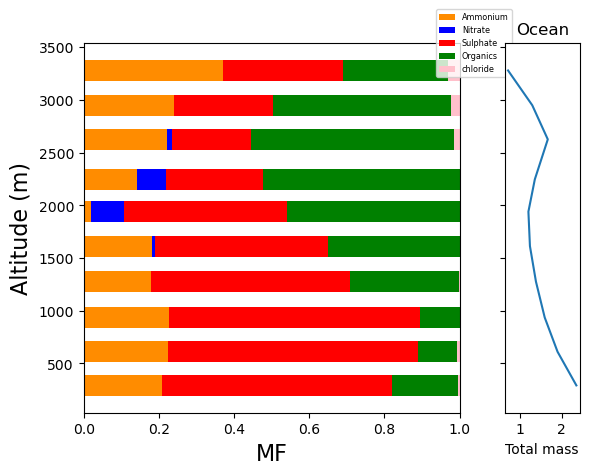

In [107]:
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], left = ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], left = ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "red", label = 'Sulphate')
ax[0].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], left = ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "green", label = 'Organics')
ax[0].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['Chl_Ave_IsoK_STP_ZIEMBA'], left = ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "pink", label = 'chloride')
ax[1].plot(ocean_transport_plot['AMS'], ocean_transport_plot['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (m)', fontsize = 16)
ax[0].set_xlabel('MF', fontsize = 16)
ax[0].set_xlim(0,1)
ax[1].set_xlabel('Total mass')
plt.title('Ocean')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')

In [108]:
# Concatenate the dataframes vertically (along rows)
North_America = pd.concat([DAY1000_subset_7, DAY1000_subset_7b, DAY1000_subset_8, DAY1000_subset_17], axis=0)

# Reset the index of the merged dataframe
North_America.reset_index(drop=True, inplace=True)
North_America = North_America[North_America['AMS'] > 0.4]
North_America.mean()

Time_Start                  2022-06-09 06:55:30.589690112
Time_Stop                   2022-06-09 06:55:31.589689856
Latitude_THORNHILL                              32.245812
Longitude_THORNHILL                            -65.019289
GPS_Altitude_THORNHILL                         547.101878
Org_Ave_IsoK_STP_ZIEMBA                          0.485574
SO4_Ave_IsoK_STP_ZIEMBA                          0.389481
NO3_Ave_IsoK_STP_ZIEMBA                          0.023228
NH4_Ave_IsoK_STP_ZIEMBA                          0.100034
Chl_Ave_IsoK_STP_ZIEMBA                          0.001684
mz44_Ave_IsoK_STP_ZIEMBA                         0.164941
mz44                                             0.116442
AMS                                               2.66251
dtype: object

In [72]:
# Concatenate the dataframes vertically (along rows)
North_America2 = pd.concat([DAY7_subset_3000, DAY7b_subset_3000, DAY8_subset_3000, DAY17_subset_3000], axis=0)

# Reset the index of the merged dataframe
North_America2.reset_index(drop=True, inplace=True)
North_America2.mean()

Time_Start                  2022-06-09 08:25:42.493775872
Time_Stop                   2022-06-09 08:25:43.493775872
Latitude_THORNHILL                              32.243963
Longitude_THORNHILL                            -65.021783
GPS_Altitude_THORNHILL                        2181.612877
Org_Ave_IsoK_STP_ZIEMBA                          0.558194
SO4_Ave_IsoK_STP_ZIEMBA                          0.282583
NO3_Ave_IsoK_STP_ZIEMBA                          0.007456
NH4_Ave_IsoK_STP_ZIEMBA                          0.145836
Chl_Ave_IsoK_STP_ZIEMBA                          0.005932
mz44_Ave_IsoK_STP_ZIEMBA                         0.088216
mz44                                             0.116682
AMS                                              1.409758
dtype: object

In [73]:
North_America_transport = pd.concat([North_America, North_America2], axis=0)
North_America_transport.reset_index(drop=True, inplace=True)
North_America_transport
nbins = 10
bins = np.linspace(North_America_transport.GPS_Altitude_THORNHILL.min(), North_America_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
North_America_transport['Bins'] = pd.cut(North_America_transport['GPS_Altitude_THORNHILL'], bins)
North_America_transport_plot = North_America_transport.groupby('Bins').mean()
North_America_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(134.322, 466.88]",2022-06-09 11:23:59.406577664,2022-06-09 11:24:00.406577664,32.246759,-65.017574,307.544785,0.491687,0.398138,0.023894,0.084758,0.001524,0.152381,0.113221,2.460328
"(466.88, 799.438]",2022-06-09 04:19:10.132353024,2022-06-09 04:19:11.132353024,32.245782,-65.016015,640.277898,0.480313,0.380633,0.022643,0.115465,0.000947,0.176729,0.124355,2.659642
"(799.438, 1131.996]",2022-06-09 01:19:50.392857088,2022-06-09 01:19:51.392857344,32.251944,-65.036834,959.047784,0.462351,0.405890,0.021116,0.106559,0.004084,0.162330,0.111014,3.085093
"(1131.996, 1464.554]",2022-06-09 10:12:58.114285824,2022-06-09 10:12:59.114285824,32.245514,-65.020691,1288.598865,0.527226,0.320162,0.017321,0.126503,0.008789,0.121800,0.108313,2.203273
"(1464.554, 1797.113]",2022-06-09 04:25:01.264705792,2022-06-09 04:25:02.264706048,32.247935,-65.035299,1624.790294,0.592092,0.270134,0.008912,0.126038,0.002824,0.102774,0.098321,1.672880
"(1797.113, 2129.671]",2022-06-09 10:16:44.442857216,2022-06-09 10:16:45.442857216,32.234086,-65.004444,1961.596634,0.627683,0.253980,0.019611,0.100893,-0.002168,0.063199,0.102231,1.060218
"(2129.671, 2462.229]",2022-06-09 05:28:40.409091072,2022-06-09 05:28:41.409090816,32.239848,-65.033209,2292.073841,0.555304,0.253097,0.021303,0.169276,0.001021,0.084367,0.115161,1.274335
"(2462.229, 2794.788]",2022-06-09 04:29:29.352941056,2022-06-09 04:29:30.352941056,32.236308,-65.042703,2619.671103,0.600994,0.246810,0.006095,0.158556,-0.012455,0.085443,0.127419,1.178976
"(2794.788, 3127.346]",2022-06-09 10:20:16.742857216,2022-06-09 10:20:17.742857216,32.238093,-64.997997,2955.912332,0.576149,0.255820,0.014782,0.138304,0.014946,0.094690,0.153149,1.131071


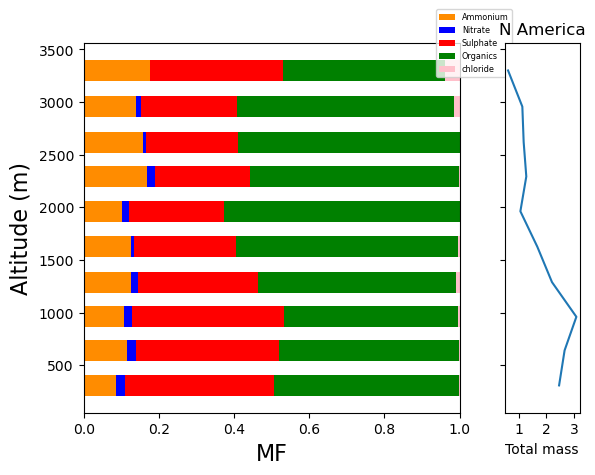

In [74]:
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], left = North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], left = North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "red", label = 'Sulphate')
ax[0].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], left = North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "green", label = 'Organics')
ax[0].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['Chl_Ave_IsoK_STP_ZIEMBA'], left = North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "pink", label = 'chloride')
ax[1].plot(North_America_transport_plot['AMS'], North_America_transport_plot['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (m)', fontsize = 16)
ax[0].set_xlabel('MF', fontsize = 16)
ax[0].set_xlim(0,1)
ax[1].set_xlabel('Total mass')
plt.title('N America')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')

In [75]:
# Concatenate the dataframes vertically (along rows)
Caribbean = pd.concat([DAY1000_subset_10, DAY1000_subset_110b, DAY1000_subset_10b, DAY1000_subset_11, DAY1000_subset_11b, DAY1000_subset_13, DAY1000_subset_13b, DAY1000_subset_14], axis=0)

# Reset the index of the merged dataframe
Caribbean.reset_index(drop=True, inplace=True)
Caribbean.mean()

Time_Start                  2022-06-12 01:22:20.224896512
Time_Stop                   2022-06-12 01:22:21.224896512
Latitude_THORNHILL                              31.811841
Longitude_THORNHILL                            -65.099931
GPS_Altitude_THORNHILL                         536.800035
Org_Ave_IsoK_STP_ZIEMBA                          0.184566
SO4_Ave_IsoK_STP_ZIEMBA                          0.646982
NO3_Ave_IsoK_STP_ZIEMBA                          0.007898
NH4_Ave_IsoK_STP_ZIEMBA                          0.158194
Chl_Ave_IsoK_STP_ZIEMBA                          0.002359
mz44_Ave_IsoK_STP_ZIEMBA                         0.006864
mz44                                            -0.400234
AMS                                               1.53137
dtype: object

In [76]:
# Concatenate the dataframes vertically (along rows)
Caribbean2 = pd.concat([DAY10_subset_3000, DAY110b_subset_3000, DAY10b_subset_3000, DAY11_subset_3000, DAY11b_subset_3000, DAY13_subset_3000, DAY13b_subset_3000, DAY14_subset_3000], axis=0)

# Reset the index of the merged dataframe
Caribbean2.reset_index(drop=True, inplace=True)
Caribbean2.mean()

Time_Start                  2022-06-12 01:04:06.219077120
Time_Stop                   2022-06-12 01:04:07.219077120
Latitude_THORNHILL                              31.829768
Longitude_THORNHILL                            -65.108813
GPS_Altitude_THORNHILL                        2196.003841
Org_Ave_IsoK_STP_ZIEMBA                          0.372305
SO4_Ave_IsoK_STP_ZIEMBA                          0.491545
NO3_Ave_IsoK_STP_ZIEMBA                         -0.010193
NH4_Ave_IsoK_STP_ZIEMBA                          0.150543
Chl_Ave_IsoK_STP_ZIEMBA                           -0.0042
mz44_Ave_IsoK_STP_ZIEMBA                         0.024441
mz44                                             0.864488
AMS                                               0.98581
dtype: object

In [77]:
# Filter the data using the condition >= 0.4
Caribbean_transport = Caribbean2[Caribbean2['Org_Ave_IsoK_STP_ZIEMBA'] >= 0.2]
Caribbean_transport = Caribbean_transport[Caribbean_transport['mz44'] <= 2]
Caribbean_transport.mean()


# Print the filtered data
#filtered_Caribbean_data

Time_Start                  2022-06-11 19:49:02.640915712
Time_Stop                   2022-06-11 19:49:03.640915712
Latitude_THORNHILL                              31.782314
Longitude_THORNHILL                            -65.134171
GPS_Altitude_THORNHILL                        2259.471193
Org_Ave_IsoK_STP_ZIEMBA                          0.482585
SO4_Ave_IsoK_STP_ZIEMBA                          0.459492
NO3_Ave_IsoK_STP_ZIEMBA                          0.006632
NH4_Ave_IsoK_STP_ZIEMBA                          0.064445
Chl_Ave_IsoK_STP_ZIEMBA                         -0.013154
mz44_Ave_IsoK_STP_ZIEMBA                         0.039873
mz44                                             0.058136
AMS                                              1.049101
dtype: object

In [78]:
# Filter the data using the condition >= 0.4
filtered_Caribbean2_data = Caribbean2[Caribbean2['AMS'] >= 0.3]

In [79]:
Caribbean_transport = pd.concat([Caribbean, Caribbean2], axis=0)
Caribbean_transport.reset_index(drop=True, inplace=True)
nbins = 10
bins = np.linspace(Caribbean_transport.GPS_Altitude_THORNHILL.min(), Caribbean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
Caribbean_transport['Bins'] = pd.cut(Caribbean_transport['GPS_Altitude_THORNHILL'], bins)
Caribbean_transport_plot = Caribbean_transport.groupby('Bins').mean()
Caribbean_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(116.448, 449.702]",2022-06-12 01:58:18.605001216,2022-06-12 01:58:19.605001472,31.796769,-65.086991,285.566849,0.157369,0.684331,0.017425,0.141217,-0.000343,-0.000232,-0.784674,1.541271
"(449.702, 782.957]",2022-06-12 00:50:14.581967104,2022-06-12 00:50:15.581967360,31.822342,-65.116175,617.447088,0.202400,0.648926,-0.003337,0.149533,0.002477,0.005114,-0.251257,1.461670
"(782.957, 1116.212]",2022-06-12 00:13:18.113207552,2022-06-12 00:13:19.113207552,31.819854,-65.104681,948.548591,0.204232,0.569166,0.005992,0.214131,0.006479,0.024821,-0.013951,1.664259
"(1116.212, 1449.467]",2022-06-12 01:11:48.385245952,2022-06-12 01:11:49.385245696,31.814160,-65.110575,1288.558494,0.229918,0.592652,0.008098,0.161950,0.007382,0.033332,0.026684,1.477356
"(1449.467, 1782.721]",2022-06-12 00:49:07.186440448,2022-06-12 00:49:08.186440704,31.793844,-65.121442,1618.248127,0.190981,0.611035,0.007885,0.173166,0.016932,0.036775,-0.055726,1.266913
"(1782.721, 2115.976]",2022-06-12 02:05:03.221311488,2022-06-12 02:05:04.221311488,31.822515,-65.078350,1948.002617,0.293003,0.583621,-0.018135,0.139639,0.001872,0.028692,0.639872,1.083819
"(2115.976, 2449.231]",2022-06-12 00:18:10.658333184,2022-06-12 00:18:11.658333440,31.807064,-65.093333,2280.819777,0.502788,0.382283,-0.007634,0.139758,-0.017194,0.020037,5.729743,0.856220
"(2449.231, 2782.486]",2022-06-12 02:02:04.032258304,2022-06-12 02:02:05.032258048,31.819770,-65.083938,2615.947190,0.424783,0.295664,-0.094780,0.364158,0.010176,0.034297,0.112982,0.771134
"(2782.486, 3115.74]",2022-06-12 00:57:46.911137280,2022-06-12 00:57:47.911137024,31.818536,-65.089036,2954.811529,0.446171,0.453078,0.021051,0.088892,-0.009192,0.004051,-0.185518,0.613396


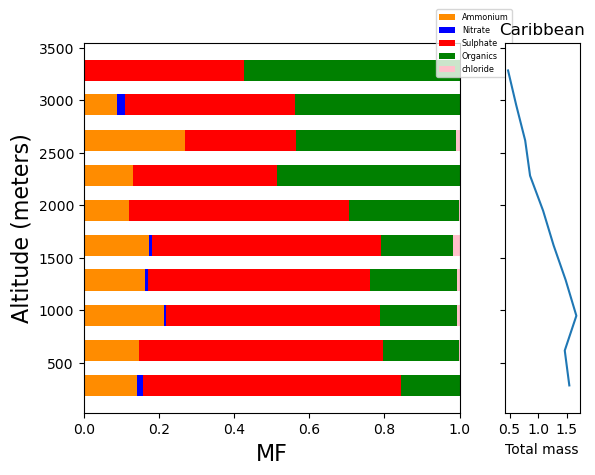

In [80]:
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], left = Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], left = Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "red", label = 'Sulphate')
ax[0].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], left = Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "green", label = 'Organics')
ax[0].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['Chl_Ave_IsoK_STP_ZIEMBA'], left = Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "pink", label = 'chloride')
ax[1].plot(Caribbean_transport_plot['AMS'], Caribbean_transport_plot['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)', fontsize = 16)
ax[0].set_xlabel('MF', fontsize = 16)
ax[0].set_xlim(0,1)
ax[1].set_xlabel('Total mass')
plt.title('Caribbean')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')

In [81]:
# Concatenate the dataframes vertically (along rows)
'''merged_df = pd.concat([Caribbean.describe(), Caribbean2.describe(), North_America.describe(), North_America2.describe(), ocean.describe(), ocean2.describe(), Africa.describe(), DAY14_subset_3000.describe()], axis=0)

# Reset the index of the merged dataframe
merged_df.reset_index(drop=False, inplace=True)

# Display the merged dataframe
merged_df
merged_df.to_csv('C:/Users/taiwoajayi/OneDrive - University of Arizona/python/chemistry_mass_description.csv')'''

"merged_df = pd.concat([Caribbean.describe(), Caribbean2.describe(), North_America.describe(), North_America2.describe(), ocean.describe(), ocean2.describe(), Africa.describe(), DAY14_subset_3000.describe()], axis=0)\n\n# Reset the index of the merged dataframe\nmerged_df.reset_index(drop=False, inplace=True)\n\n# Display the merged dataframe\nmerged_df\nmerged_df.to_csv('C:/Users/taiwoajayi/OneDrive - University of Arizona/python/chemistry_mass_description.csv')"

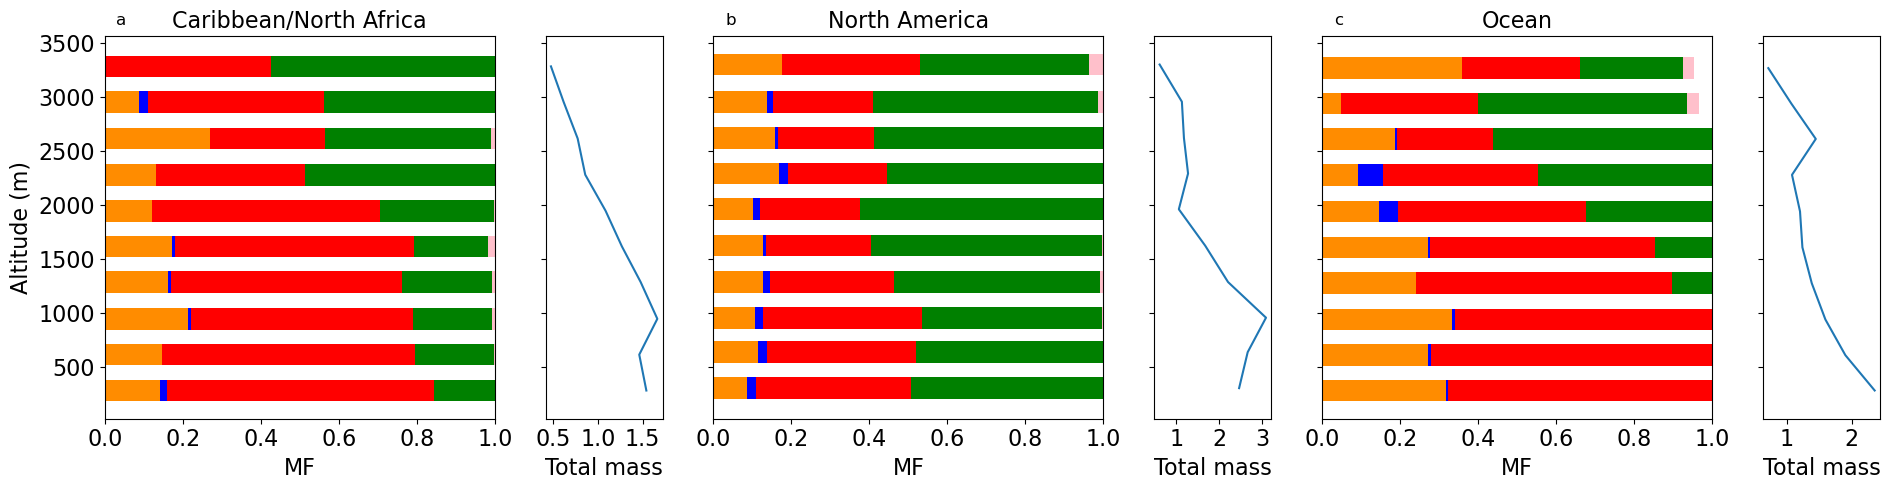

In [82]:
from matplotlib.transforms import ScaledTranslation

# Create a 1x6 subplot grid with appropriate width ratios
fig, axes = plt.subplots(1, 6, figsize=(19, 5), gridspec_kw={'width_ratios': [20, 6, 20, 6, 20, 6]}, sharey = True)

# Subplot 1: Caribbean_transport_plot
axes[0].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height=200, color="darkorange", label='Ammonium')
axes[0].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], left=Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height=200, color="blue", label='Nitrate')
axes[0].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], left=Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'] + Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], height=200, color="red", label='Sulphate')
axes[0].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], left=Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'] + Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'] + Caribbean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], height=200, color="green", label='Organics')
axes[0].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['Chl_Ave_IsoK_STP_ZIEMBA'], left=Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'] + Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'] + Caribbean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'] + Caribbean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], height=200, color="pink", label='chloride')
axes[1].plot(Caribbean_transport_plot['AMS'], Caribbean_transport_plot['GPS_Altitude_THORNHILL'], label='Total_mass')
axes[0].set_ylabel('Altitude (m)', fontsize=16)
axes[0].set_xlabel('MF', fontsize=16)
axes[0].set_xlim(0, 1)
axes[1].xaxis.set_tick_params(labelsize=16)
axes[1].set_xlabel('Total mass', fontsize=16)
axes[0].set_title('Caribbean/North Africa', fontsize = 16)
axes[0].text(0.04, 1.06, 'a',
    transform=axes[0].transAxes + ScaledTranslation(-0.04, 0, fig.dpi_scale_trans),
    fontsize='large', verticalalignment='top',
    bbox=dict(facecolor='1', edgecolor='none', pad=3.0))

# Subplot 2: North_America_transport_plot
axes[2].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "darkorange", label = 'Ammonium')
axes[2].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], left = North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "blue", label = 'Nitrate')
axes[2].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], left = North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "red", label = 'Sulphate')
axes[2].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], left = North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "green", label = 'Organics')
axes[2].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['Chl_Ave_IsoK_STP_ZIEMBA'], left = North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "pink", label = 'chloride')
axes[3].plot(North_America_transport_plot['AMS'], North_America_transport_plot['GPS_Altitude_THORNHILL'], label = 'Total_mass')
axes[2].set_xlabel('MF', fontsize=16)
axes[2].set_xlim(0, 1)
axes[3].set_xlabel('Total mass', fontsize=16)
axes[2].set_title('North America', fontsize = 16)
axes[2].text(0.04, 1.06, 'b',
    transform=axes[2].transAxes + ScaledTranslation(-0.04, 0, fig.dpi_scale_trans),
    fontsize='large', verticalalignment='top',
    bbox=dict(facecolor='1', edgecolor='none', pad=3.0))

# Subplot 3: ocean_transport_plot
axes[4].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height=200, color="darkorange", label='Ammonium')
axes[4].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], left=ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height=200, color="blue", label='Nitrate')
axes[4].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], left=ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'] + ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], height=200, color="red", label='Sulphate')
axes[4].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], left=ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'] + ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'] + ocean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], height=200, color="green", label='Organics')
axes[4].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['Chl_Ave_IsoK_STP_ZIEMBA'], left=ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'] + ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'] + ocean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'] + ocean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], height=200, color="pink", label='chloride')
axes[5].plot(ocean_transport_plot['AMS'], ocean_transport_plot['GPS_Altitude_THORNHILL'], label='Total_mass')
#axes[4].set_ylabel('Altitude (m)', fontsize=14)
axes[4].set_xlabel('MF', fontsize=16)
axes[4].set_xlim(0, 1)
#axes[4].legend(bbox_to_anchor=(1.18, 1), loc = 'right', fontsize='small')
axes[5].set_xlabel('Total mass', fontsize=16)
for ax_ in axes:
    ax_.tick_params(axis='both', which='both', labelsize=16)
axes[4].set_title('Ocean', fontsize = 16)
axes[4].text(0.04, 1.06, 'c',
    transform=axes[4].transAxes + ScaledTranslation(-0.04, 0, fig.dpi_scale_trans),
    fontsize='large', verticalalignment='top',
    bbox=dict(facecolor='1', edgecolor='none', pad=3.0))

# Show the plot
plt.tight_layout()
plt.show()


In [83]:
'''from matplotlib.transforms import ScaledTranslation

# Create a 4x2 subplot grid with appropriate width ratios
fig, axes = plt.subplots(2, 4, figsize=(10, 7), gridspec_kw={'width_ratios': [20, 5, 20, 5]}, sharey='all')

# Subplot 1: filtered_Africa_data
axes[0, 0].barh(filtered_Africa_data['GPS_Altitude_THORNHILL'], filtered_Africa_data['NH4_Ave_IsoK_STP_ZIEMBA'], height=200, color="darkorange", label='Ammonium')
axes[0, 0].barh(filtered_Africa_data['GPS_Altitude_THORNHILL'], filtered_Africa_data['NO3_Ave_IsoK_STP_ZIEMBA'], left=filtered_Africa_data['NH4_Ave_IsoK_STP_ZIEMBA'], height=200, color="blue", label='Nitrate')
axes[0, 0].barh(filtered_Africa_data['GPS_Altitude_THORNHILL'], filtered_Africa_data['SO4_Ave_IsoK_STP_ZIEMBA'], left=filtered_Africa_data['NH4_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['NO3_Ave_IsoK_STP_ZIEMBA'], height=200, color="red", label='Sulphate')
axes[0, 0].barh(filtered_Africa_data['GPS_Altitude_THORNHILL'], filtered_Africa_data['Org_Ave_IsoK_STP_ZIEMBA'], left=filtered_Africa_data['NH4_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['NO3_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['SO4_Ave_IsoK_STP_ZIEMBA'], height=200, color="green", label='Organics')
axes[0, 0].barh(filtered_Africa_data['GPS_Altitude_THORNHILL'], filtered_Africa_data['Chl_Ave_IsoK_STP_ZIEMBA'], left=filtered_Africa_data['NH4_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['NO3_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['SO4_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['Org_Ave_IsoK_STP_ZIEMBA'], height=200, color="pink", label='chloride')
axes[0, 1].plot(filtered_Africa_data['AMS'], filtered_Africa_data['GPS_Altitude_THORNHILL'], label='Total_mass')
axes[0, 0].set_ylabel('Altitude (m)', fontsize=14)
#axes[0, 0].set_xlabel('MF', fontsize=16)
axes[0, 0].set_xlim(0, 1)
axes[0, 1].xaxis.set_tick_params(labelsize=8)
#axes[0, 1].set_xlabel('Total mass')
#axes[0, 0].legend(bbox_to_anchor=(1.15, 1), loc='right', fontsize='xx-small')
axes[0, 0].set_title('North Africa')
axes[0, 0].text(0.04, 1.06, 'a',
    transform=axes[0, 0].transAxes + ScaledTranslation(-0.04, 0, fig.dpi_scale_trans),
    fontsize='large', verticalalignment='top',
    bbox=dict(facecolor='1', edgecolor='none', pad=3.0))

# Subplot 2: Caribbean_transport_plot
axes[0, 2].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height=200, color="darkorange", label='Ammonium')
axes[0, 2].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], left=Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height=200, color="blue", label='Nitrate')
axes[0, 2].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], left=Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], height=200, color="red", label='Sulphate')
axes[0, 2].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], left=Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], height=200, color="green", label='Organics')
axes[0, 2].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['Chl_Ave_IsoK_STP_ZIEMBA'], left=Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], height=200, color="pink", label='chloride')
axes[0, 3].plot(Caribbean_transport_plot['AMS'], Caribbean_transport_plot['GPS_Altitude_THORNHILL'], label='Total_mass')
#axes[0, 0].set_ylabel('Altitude (m)', fontsize=16)
#axes[1, 0].set_xlabel('MF', fontsize=16)
axes[0, 2].set_xlim(0, 1)
axes[0, 3].xaxis.set_tick_params(labelsize=8)
#axes[1, 1].set_xlabel('Total mass')
#axes[1, 0].legend(bbox_to_anchor=(1.15, 1), loc='right', fontsize='xx-small')
axes[0, 2].set_title('Caribbean')
axes[0, 2].text(0.04, 1.06, 'b',
    transform=axes[0, 2].transAxes + ScaledTranslation(-0.04, 0, fig.dpi_scale_trans),
    fontsize='large', verticalalignment='top',
    bbox=dict(facecolor='1', edgecolor='none', pad=3.0))

# Subplot 3: North_America_transport_plot
axes[1, 0].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height=200, color="darkorange", label='Ammonium')
axes[1, 0].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], left=North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height=200, color="blue", label='Nitrate')
axes[1, 0].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], left=North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], height=200, color="red", label='Sulphate')
axes[1, 0].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], left=North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], height=200, color="green", label='Organics')
axes[1, 0].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['Chl_Ave_IsoK_STP_ZIEMBA'], left=North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], height=200, color="pink", label='chloride')
axes[1, 1].plot(North_America_transport_plot['AMS'], North_America_transport_plot['GPS_Altitude_THORNHILL'], label='Total_mass')
axes[1, 0].set_ylabel('Altitude (m)', fontsize=14)
axes[1, 0].set_xlabel('MF', fontsize=14)
axes[1, 0].set_xlim(0, 1)
axes[1, 1].set_xlabel('Total mass', fontsize=14)
#axes[2, 0].legend(bbox_to_anchor=(1.15, 1), loc='right', fontsize='xx-small')
axes[1, 0].set_title('North America')
axes[1, 0].text(0.04, 1.06, 'c',
    transform=axes[1, 0].transAxes + ScaledTranslation(-0.04, 0, fig.dpi_scale_trans),
    fontsize='large', verticalalignment='top',
    bbox=dict(facecolor='1', edgecolor='none', pad=3.0))

# Subplot 4: ocean_transport_plot
axes[1, 2].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height=200, color="darkorange", label='Ammonium')
axes[1, 2].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], left=ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height=200, color="blue", label='Nitrate')
axes[1, 2].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], left=ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], height=200, color="red", label='Sulphate')
axes[1, 2].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], left=ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], height=200, color="green", label='Organics')
axes[1, 2].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['Chl_Ave_IsoK_STP_ZIEMBA'], left=ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], height=200, color="pink", label='chloride')
axes[1, 3].plot(ocean_transport_plot['AMS'], ocean_transport_plot['GPS_Altitude_THORNHILL'], label='Total_mass')
#axes[1, 2].set_ylabel('Altitude (m)', fontsize=16)
axes[1, 2].set_xlabel('MF', fontsize=14)
axes[1, 2].set_xlim(0, 1)
axes[1, 3].set_xlabel('Total mass', fontsize=13.4)
axes[1, 2].set_title('Ocean')
axes[1, 2].text(0.04, 1.06, 'd',
    transform=axes[1, 2].transAxes + ScaledTranslation(-0.04, 0, fig.dpi_scale_trans),
    fontsize='large', verticalalignment='top',
    bbox=dict(facecolor='1', edgecolor='none', pad=3.0))
#axes[3, 0].legend(bbox_to_anchor=(1.15, 1), loc='right', fontsize='xx-small')
#for ax in axes.flatten():
 #   ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
# Show the plot
plt.tight_layout()
plt.show()'''

'from matplotlib.transforms import ScaledTranslation\n\n# Create a 4x2 subplot grid with appropriate width ratios\nfig, axes = plt.subplots(2, 4, figsize=(10, 7), gridspec_kw={\'width_ratios\': [20, 5, 20, 5]}, sharey=\'all\')\n\n# Subplot 1: filtered_Africa_data\naxes[0, 0].barh(filtered_Africa_data[\'GPS_Altitude_THORNHILL\'], filtered_Africa_data[\'NH4_Ave_IsoK_STP_ZIEMBA\'], height=200, color="darkorange", label=\'Ammonium\')\naxes[0, 0].barh(filtered_Africa_data[\'GPS_Altitude_THORNHILL\'], filtered_Africa_data[\'NO3_Ave_IsoK_STP_ZIEMBA\'], left=filtered_Africa_data[\'NH4_Ave_IsoK_STP_ZIEMBA\'], height=200, color="blue", label=\'Nitrate\')\naxes[0, 0].barh(filtered_Africa_data[\'GPS_Altitude_THORNHILL\'], filtered_Africa_data[\'SO4_Ave_IsoK_STP_ZIEMBA\'], left=filtered_Africa_data[\'NH4_Ave_IsoK_STP_ZIEMBA\']+filtered_Africa_data[\'NO3_Ave_IsoK_STP_ZIEMBA\'], height=200, color="red", label=\'Sulphate\')\naxes[0, 0].barh(filtered_Africa_data[\'GPS_Altitude_THORNHILL\'], filtered_Af

In [84]:
'''# Create a 4x2 subplot grid with appropriate width ratios
fig, axes = plt.subplots(4, 2, figsize=(5, 15), gridspec_kw={'width_ratios': [20, 4]}, sharey='all')

# Subplot 1: filtered_Africa_data
axes[0, 0].barh(filtered_Africa_data['GPS_Altitude_THORNHILL'], filtered_Africa_data['NH4_Ave_IsoK_STP_ZIEMBA'], height=200, color="darkorange", label='Ammonium')
axes[0, 0].barh(filtered_Africa_data['GPS_Altitude_THORNHILL'], filtered_Africa_data['NO3_Ave_IsoK_STP_ZIEMBA'], left=filtered_Africa_data['NH4_Ave_IsoK_STP_ZIEMBA'], height=200, color="blue", label='Nitrate')
axes[0, 0].barh(filtered_Africa_data['GPS_Altitude_THORNHILL'], filtered_Africa_data['SO4_Ave_IsoK_STP_ZIEMBA'], left=filtered_Africa_data['NH4_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['NO3_Ave_IsoK_STP_ZIEMBA'], height=200, color="red", label='Sulphate')
axes[0, 0].barh(filtered_Africa_data['GPS_Altitude_THORNHILL'], filtered_Africa_data['Org_Ave_IsoK_STP_ZIEMBA'], left=filtered_Africa_data['NH4_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['NO3_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['SO4_Ave_IsoK_STP_ZIEMBA'], height=200, color="green", label='Organics')
axes[0, 0].barh(filtered_Africa_data['GPS_Altitude_THORNHILL'], filtered_Africa_data['Chl_Ave_IsoK_STP_ZIEMBA'], left=filtered_Africa_data['NH4_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['NO3_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['SO4_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['Org_Ave_IsoK_STP_ZIEMBA'], height=200, color="pink", label='chloride')
axes[0, 1].plot(filtered_Africa_data['AMS'], filtered_Africa_data['GPS_Altitude_THORNHILL'], label='Total_mass')
axes[0, 0].set_ylabel('Altitude (m)', fontsize=16)
#axes[0, 0].set_xlabel('MF', fontsize=16)
axes[0, 0].set_xlim(0, 1)
#axes[0, 1].set_xlabel('Total mass')
#axes[0, 0].legend(bbox_to_anchor=(1.15, 1), loc='right', fontsize='xx-small')
axes[0, 1].xaxis.set_tick_params(labelsize=8)
axes[0, 0].set_title('N Africa')

# Subplot 2: Caribbean_transport_plot
axes[1, 0].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height=200, color="darkorange", label='Ammonium')
axes[1, 0].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], left=Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height=200, color="blue", label='Nitrate')
axes[1, 0].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], left=Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], height=200, color="red", label='Sulphate')
axes[1, 0].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], left=Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], height=200, color="green", label='Organics')
axes[1, 0].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['Chl_Ave_IsoK_STP_ZIEMBA'], left=Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], height=200, color="pink", label='chloride')
axes[1, 1].plot(Caribbean_transport_plot['AMS'], Caribbean_transport_plot['GPS_Altitude_THORNHILL'], label='Total_mass')
axes[1, 0].set_ylabel('Altitude (m)', fontsize=16)
#axes[1, 0].set_xlabel('MF', fontsize=16)
axes[1, 0].set_xlim(0, 1)
axes[1, 1].xaxis.set_tick_params(labelsize=8)
axes[1, 1].set_xlabel('Total mass')
#axes[1, 0].legend(bbox_to_anchor=(1.15, 1), loc='right', fontsize='xx-small')
axes[1, 0].set_title('Caribbean')

# Subplot 3: North_America_transport_plot
axes[2, 0].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height=200, color="darkorange", label='Ammonium')
axes[2, 0].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], left=North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height=200, color="blue", label='Nitrate')
axes[2, 0].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], left=North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], height=200, color="red", label='Sulphate')
axes[2, 0].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], left=North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], height=200, color="green", label='Organics')
axes[2, 0].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['Chl_Ave_IsoK_STP_ZIEMBA'], left=North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], height=200, color="pink", label='chloride')
axes[2, 1].plot(North_America_transport_plot['AMS'], North_America_transport_plot['GPS_Altitude_THORNHILL'], label='Total_mass')
axes[2, 0].set_ylabel('Altitude (m)', fontsize=16)
#axes[2, 0].set_xlabel('MF', fontsize=16)
axes[2, 0].set_xlim(0, 1)
#axes[2, 1].set_xlabel('Total mass')
#axes[2, 0].legend(bbox_to_anchor=(1.15, 1), loc='right', fontsize='xx-small')
axes[2, 0].set_title('North America')

# Subplot 4: ocean_transport_plot
axes[3, 0].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height=200, color="darkorange", label='Ammonium')
axes[3, 0].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], left=ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height=200, color="blue", label='Nitrate')
axes[3, 0].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], left=ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], height=200, color="red", label='Sulphate')
axes[3, 0].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], left=ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], height=200, color="green", label='Organics')
axes[3, 0].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['Chl_Ave_IsoK_STP_ZIEMBA'], left=ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], height=200, color="pink", label='chloride')
axes[3, 1].plot(ocean_transport_plot['AMS'], ocean_transport_plot['GPS_Altitude_THORNHILL'], label='Total_mass')
axes[3, 0].set_ylabel('Altitude (m)', fontsize=16)
axes[3, 0].set_xlabel('MF', fontsize=16)
axes[3, 0].set_xlim(0, 1)
axes[3, 1].set_xlabel('Total mass')
#axes[3, 0].legend(bbox_to_anchor=(1.15, 1), loc='right', fontsize='xx-small')
axes[3, 0].set_title('Ocean')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()'''


'# Create a 4x2 subplot grid with appropriate width ratios\nfig, axes = plt.subplots(4, 2, figsize=(5, 15), gridspec_kw={\'width_ratios\': [20, 4]}, sharey=\'all\')\n\n# Subplot 1: filtered_Africa_data\naxes[0, 0].barh(filtered_Africa_data[\'GPS_Altitude_THORNHILL\'], filtered_Africa_data[\'NH4_Ave_IsoK_STP_ZIEMBA\'], height=200, color="darkorange", label=\'Ammonium\')\naxes[0, 0].barh(filtered_Africa_data[\'GPS_Altitude_THORNHILL\'], filtered_Africa_data[\'NO3_Ave_IsoK_STP_ZIEMBA\'], left=filtered_Africa_data[\'NH4_Ave_IsoK_STP_ZIEMBA\'], height=200, color="blue", label=\'Nitrate\')\naxes[0, 0].barh(filtered_Africa_data[\'GPS_Altitude_THORNHILL\'], filtered_Africa_data[\'SO4_Ave_IsoK_STP_ZIEMBA\'], left=filtered_Africa_data[\'NH4_Ave_IsoK_STP_ZIEMBA\']+filtered_Africa_data[\'NO3_Ave_IsoK_STP_ZIEMBA\'], height=200, color="red", label=\'Sulphate\')\naxes[0, 0].barh(filtered_Africa_data[\'GPS_Altitude_THORNHILL\'], filtered_Africa_data[\'Org_Ave_IsoK_STP_ZIEMBA\'], left=filtered_Africa_d